# Data Import and Wrangling

## Load Modules

In [1]:
#system
import warnings
import sys
import subprocess
import pkg_resources
import os
from os import path
from datetime import date

# # scikit-misc for loess smoothing
# required = {'outlier_utils','scikit-misc','scikit_posthocs'}
# installed = {pkg.key for pkg in pkg_resources.working_set}
# missing = required - installed

# if missing:
#     python = sys.executable
#     subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)
# from scipy import misc

#stats
import pandas as pd
import numpy as np
import math
from pandas.api.types import CategoricalDtype
import outliers
from scipy import stats
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from numpy import cov
from sklearn.metrics import mean_squared_error
from math import sqrt

#scale and center dataset
#https://scikit-learn.org/stable/modules/preprocessing.html 
from sklearn import preprocessing

#scipy
from scipy import stats as sci
from scipy.stats import linregress
from scipy.stats.mstats import gmean
from scipy.stats import gstd
from scipy.stats import kendalltau
from scipy.optimize import curve_fit
# import scikit_posthocs as sp

#sklearn related
from sklearn.linear_model import LinearRegression
from sklearn.utils import resample as bootstrap
import skmisc

#plotting
from plotnine import *
import matplotlib
from matplotlib import cm
import matplotlib.pyplot as mplt
%matplotlib inline
from mizani.formatters import scientific_format
from pylab import * #colormap extraction
import seaborn as sns 

#scripts
from reprocess_qpcr import *
from calculations import *
from read_gsheets import *
from qa_qc import *

#sheets
rna_tab = 'sample_inventory'
ww_tab='site_lookup'
facility_lookup='site_lookup' #from Hannah: why are ww_tab and facility_lookup the same?
qpcr_results_tab = 'QuantStudio_raw_data'
qpcr_plates_tab = 'Plate_info'
cases_tab='casedata'
chem_data = 'physicochemical_data'
master="master_curves"

warnings.filterwarnings('ignore') #toggle plotnine warnings

In [2]:
#saving figures and tables
dir=os.getcwd()
dir=os.path.join(dir, "Figures")

## Local attributes

In [3]:
#made this by editing code from here https://gist.github.com/AllenDowney/818f6153ef316aee80467c51faee80f8
import statsmodels.api as sm
from contextlib import suppress
smlowess = sm.nonparametric.lowess

# from skmisc.loess import loess as loess_klass 

# import warnings
# from contextlib import suppress
# a=a.sort_values("date_sampling")

def pnlowess(y,x, **params):
    for k in ('is_sorted', 'return_sorted'):
        with suppress(KeyError):
            del params['method_args'][k]
            warnings.warn(
                "Smoothing method argument: {}, "
                "has been ignored.".format(k)
            )

    result = smlowess(y, x,
                      frac=params['span'],
                      is_sorted=True,
                      **params['method_args'])
    data = pd.DataFrame({
        'x': result[:, 0],
        'y': result[:, 1]})
    return(data)


def make_loess(series, wk):
    endog = series.values
    exog = series.index.values
    tot=len(endog)
    fr=wk/tot

    smooth = smlowess(endog, exog,frac=fr, is_sorted=True) #is_sorted needs to be true when working with dates (and need to make sure it is actually sorted before using this function)
    index, data = np.transpose(smooth)
    
    return pd.Series(data, index=pd.to_datetime(index))



#based on code from here https://stackoverflow.com/questions/25571882/pandas-columns-correlation-with-statistical-significance
def calculate_pvalues(df_full):
    final_ken=pd.DataFrame()
    for loc in locs:
      df=df_full[df_full.location==loc].copy()
      df = df._get_numeric_data()
      dfcols = pd.DataFrame(columns=df.columns)
      values = dfcols.transpose().join(dfcols, how='outer')
      for r in df.columns:
          for c in df.columns:
              values[r][c] = kendalltau(df[r], df[c], nan_policy='omit')[1]

      values=values.reset_index()[values.index.isin(row1)].drop(row1,axis=1)
      values["location"]=loc
      final_ken=final_ken.append(values)
    return final_ken

def calculate_kendall(df_full):
    final_ken=pd.DataFrame()
    for loc in locs:
      df=df_full[df_full.location==loc].copy()
      df = df._get_numeric_data()
      dfcols = pd.DataFrame(columns=df.columns)
      values = dfcols.transpose().join(dfcols, how='outer')
      for r in df.columns:
          for c in df.columns:
              values[r][c] = round(kendalltau(df[r], df[c], nan_policy='omit')[0], 4)

      values=values.reset_index()[values.index.isin(row1)].drop(row1,axis=1)
      values["location"]=loc
      final_ken=final_ken.append(values)
    return final_ken

def calculate_kendalldt(df_full):
    final_ken=pd.DataFrame()
    for loc in locs:
      df=df_full[df_full.date_type==loc].copy()
      df = df._get_numeric_data()
      dfcols = pd.DataFrame(columns=df.columns)
      values = dfcols.transpose().join(dfcols, how='outer')
      for r in df.columns:
          for c in df.columns:
              values[r][c] = round(kendalltau(df[r], df[c], nan_policy='omit')[0], 4)

      values=values.reset_index()[values.index.isin(row1)].drop(row1,axis=1)
      values["date_type"]=loc
      final_ken=final_ken.append(values)
    return final_ken


def dataframes_kendall(wBDL, woBDL, condition, lis_t2):
  def kendall_pval(x,y):
          return kendalltau(x,y)[1]

  def kendall_kval(x,y):
          return kendalltau(x,y)[0]
  wBDL_pval=wBDL.groupby(['location']).corr(method=kendall_pval).reset_index()
  wBDL_pval=wBDL_pval[wBDL_pval.level_1!= n_new_sm].drop(lis_t2, axis=1)
  wBDL_pval.columns=["location", "Target", "pval"]
  wBDL_kval=wBDL.groupby(['location']).corr(method=kendall_kval).reset_index()
  wBDL_kval=wBDL_kval[wBDL_kval.level_1!= n_new_sm].drop(lis_t2, axis=1)
  wBDL_kval.columns=["location", "Target", "kval"]
  wBDL=wBDL_kval.merge(wBDL_pval)
  wBDL["BDL"]="BLoD"
  wBDL["condition"]= wBDL["location"]+" "+condition
  woBDL_pval=woBDL.groupby(['location']).corr(method=kendall_pval).reset_index()
  woBDL_pval=woBDL_pval[woBDL_pval.level_1!= n_new_sm].drop(lis_t2, axis=1)
  woBDL_pval.columns=["location", "Target", "pval"]
  woBDL_kval=woBDL.groupby(['location']).corr(method=kendall_kval).reset_index()
  woBDL_kval=woBDL_kval[woBDL_kval.level_1!= n_new_sm].drop(lis_t2, axis=1)
  woBDL_kval.columns=["location", "Target", "kval"]
  woBDL=woBDL_kval.merge(woBDL_pval)
  woBDL["BDL"]="without  BLoD"
  woBDL["condition"]= woBDL["location"]+" "+condition
  fin=wBDL.append(woBDL).reset_index(drop=True)
  return(fin)

def dataframes_kendalldt(wBDL, woBDL, condition,lis_t2):
  def kendall_pval(x,y):
          return kendalltau(x,y)[1]

  def kendall_kval(x,y):
          return kendalltau(x,y)[0]
  wBDL_pval=wBDL.groupby(['date_type']).corr(method=kendall_pval).reset_index()
  wBDL_pval=wBDL_pval[wBDL_pval.level_1!= n_new_sm].drop(lis_t2, axis=1)
  wBDL_pval.columns=["date_type", "Target", "pval"]
  wBDL_kval=wBDL.groupby(['date_type']).corr(method=kendall_kval).reset_index()
  wBDL_kval=wBDL_kval[wBDL_kval.level_1!= n_new_sm].drop(lis_t2, axis=1)
  wBDL_kval.columns=["date_type", "Target", "kval"]
  wBDL=wBDL_kval.merge(wBDL_pval)
  wBDL["BDL"]="BLoD"
  wBDL["condition"]= wBDL["date_type"]+" "+condition
  woBDL_pval=woBDL.groupby(['date_type']).corr(method=kendall_pval).reset_index()
  woBDL_pval=woBDL_pval[woBDL_pval.level_1!= n_new_sm].drop(lis_t2, axis=1)
  woBDL_pval.columns=["date_type", "Target", "pval"]
  woBDL_kval=woBDL.groupby(['date_type']).corr(method=kendall_kval).reset_index()
  woBDL_kval=woBDL_kval[woBDL_kval.level_1!= n_new_sm].drop(lis_t2, axis=1)
  woBDL_kval.columns=["date_type", "Target", "kval"]
  woBDL=woBDL_kval.merge(woBDL_pval)
  woBDL["BDL"]="without  BLoD"
  woBDL["condition"]= woBDL["date_type"]+" "+condition
  fin=wBDL.append(woBDL).reset_index(drop=True)
  return(fin)

In [4]:
pd.set_option('display.float_format', '{:.2E}'.format)

## Load datasets

In [5]:
# metadata
sample_data = read_sample_data(rna_tab, facility_lookup)
copy_sd=sample_data.copy()

sample_data["RNA_yield_quantification"]=np.nan
sample_data["DNA_yield_quantification"]=np.nan
sample_data.loc[sample_data.RNA_ng_ul_qubit_all=='<5','RNA_yield_quantification']='below quantification limit'
sample_data.loc[(sample_data.RNA_ng_ul_qubit_all!="")&(sample_data.RNA_ng_ul_qubit_all!='<5'),'RNA_yield_quantification']='quantifiable'
sample_data.loc[sample_data.RNA_ng_ul_qubit_all=='<5','RNA_ng_ul_qubit_all']=2.5
sample_data.loc[sample_data.DNA_ng_ul_qubit_all=='<0.05','DNA_yield_quantification']='below quantification limit'
sample_data.loc[((sample_data.DNA_ng_ul_qubit_all!=""))&(sample_data.DNA_ng_ul_qubit_all!='<0.05'),'DNA_yield_quantification']='quantifiable'
sample_data.loc[sample_data.DNA_ng_ul_qubit_all=='<0.05','DNA_ng_ul_qubit_all']=0.025

#get RNA data into editable form
sample_data['elution_vol_ul']=pd.to_numeric(sample_data.elution_vol_ul)
sample_data['weight_vol_extracted_ml']=pd.to_numeric(sample_data.weight_vol_extracted_ml)
sample_data['RNA_ng_ul_qubit_all']=pd.to_numeric(sample_data.RNA_ng_ul_qubit_all)
sample_data['DNA_ng_ul_qubit_all']=pd.to_numeric(sample_data.DNA_ng_ul_qubit_all)
sample_data['RNA_yield_ext']=(sample_data.RNA_ng_ul_qubit_all*sample_data.elution_vol_ul)
sample_data['DNA_yield_ext']=(sample_data.DNA_ng_ul_qubit_all*sample_data.elution_vol_ul)
sample_data['RNA_yield']=(sample_data.RNA_ng_ul_qubit_all*sample_data.elution_vol_ul)/sample_data.weight_vol_extracted_ml
sample_data['DNA_yield']=(sample_data.DNA_ng_ul_qubit_all*sample_data.elution_vol_ul)/sample_data.weight_vol_extracted_ml
sample_data['date_sampling']=pd.to_datetime(sample_data['date_sampling'])

#Load master curve
master_curve=pd.read_csv('data_files/'+master+'.csv').dropna(how='all')
master_curve.LoD_Cq=pd.to_numeric(master_curve.LoD_Cq)
master_curve.m=pd.to_numeric(master_curve.m)
master_curve.b=pd.to_numeric(master_curve.b)
master_curve.LoD_quantity=pd.to_numeric(master_curve.LoD_quantity)
master_curve.lowest_quantity=pd.to_numeric(master_curve.lowest_quantity)

# plotting LoD lines for each plot
master_curve["LoD_gc_per_L"]= (master_curve.lowest_quantity/5)*1000*200/50
N1_LoD=master_curve.loc[master_curve.Target=="N1", "LoD_gc_per_L"].item()
S18_LoD=master_curve.loc[master_curve.Target=="18S", "LoD_gc_per_L"].item()
PMMoV_LoD=master_curve.loc[master_curve.Target=="PMMoV", "LoD_gc_per_L"].item()
C_LoD=master_curve.loc[master_curve.Target=="crAss", "LoD_gc_per_L"].item()
bact_LoD=master_curve.loc[master_curve.Target=="bact", "LoD_gc_per_L"].item()

#qpcr data
qpcr_raw = read_qpcr_data(qpcr_results_tab, qpcr_plates_tab)
plates=[ 68, 85, 86, 87,88, 91, 92, 93, 94, 95, 96, 99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121, 123, 124,125,126,127, 128, 129, 130, 131, 132 ]
plates_LTM= [ 87,88,  92, 93, 94, 95, 96, 99,100,101,102,123, 124,125,126,127, 128, 129, 130, 131, 132 ]
qpcr_raw=qpcr_raw[qpcr_raw.plate_id.isin(plates)].copy()
# qpcr_raw=qpcr_raw[qpcr_raw.LoD_testing != "Y"].copy()
qpcr_processed, std_curve_df, dilution_expts_df,raw_outliers_flagged_df, control_df = process_qpcr_raw(qpcr_raw, 'grubbs_only', master=master_curve, use_master_curve=True)

# merge with sample data
qpcr_averaged = qpcr_processed.merge(sample_data, how='left', left_on='Sample', right_on='sample_id')
qpcr_averaged = qpcr_averaged[(qpcr_averaged.Sample != 'NTC') &
                              (qpcr_averaged.Target != 'Xeno') &
                              (qpcr_averaged.inhibition_testing == "N")] # Remove spike and dilute inhibition testing from qPCR averaged

# calculations
qpcr_averaged['gc_per_L'] = calculate_gc_per_l(qpcr_averaged) # get gc/L
qpcr_averaged = normalize_to_pmmov(qpcr_averaged)
qpcr_averaged_merged= get_extraction_control(qpcr_averaged)
und_N1=qpcr_averaged_merged[qpcr_averaged_merged.Target=="N1"][["is_undetermined_count", "replicate_init_count", "Sample"]].copy()
und_N1.columns=["is_undetermined_N1", "is_undetermined_N1_total", "Sample"]
bloq_N1=qpcr_averaged_merged[qpcr_averaged_merged.Target=="N1"][["is_bloq_count", "replicate_init_count",  "gc_per_L","Sample"]].copy()
bloq_N1["is_bloq_bio_N1"]=False
bloq_N1.loc[ (bloq_N1.gc_per_L < N1_LoD ), "is_bloq_bio_N1"]=True
bloq_N1=bloq_N1.drop("gc_per_L", axis=1)
bloq_N1.columns=["is_bloq_N1", "is_bloq_N1_total","Sample","is_bloq_bio_N1"]

qpcr_averaged_merged=qpcr_averaged_merged.merge(und_N1, how='left')
qpcr_averaged_merged=qpcr_averaged_merged.merge(bloq_N1, how='left')

# test inhibition
qpcr_averaged_merged, xeno_inhib_full,xeno_control=xeno_inhibition_test(raw_outliers_flagged_df,qpcr_averaged_merged)
xeno_inhib=xeno_inhib_full.merge(sample_data, left_on='Sample', right_on='sample_id',  how='left').copy()
xeno_inhib=xeno_inhib[(xeno_inhib['batch'].str.contains("B", na=False))].copy()
x_plates=xeno_inhib.plate_id.unique()
xeno_control=xeno_control[xeno_control.plate_id.isin(x_plates)].copy()

# #remove pop up lab batches
# qpcr_averaged_merged=qpcr_averaged_merged[(qpcr_averaged_merged['batch'].str.contains("B", na=False))].copy()
# nI=["RV","SD2","SRWS","SR"]
# qpcr_averaged_merged=qpcr_averaged_merged[~qpcr_averaged_merged.interceptor.isin(nI)].copy()

#control df
control_df.loc[control_df.Task!="Negative Control", "Task"]="PBS control"
control_df=control_df[control_df.plate_id.isin(plates) ].copy()


PMMoV
   Quantity  Cq_mean  negatives  total   fr_pos
0  1.00E+02 3.69E+01          1     18 9.44E-01
1  1.00E+03 3.39E+01          0     18 1.00E+00
2  1.00E+04 3.04E+01          0     18 1.00E+00
3  1.00E+05 2.64E+01          0     18 1.00E+00
4  1.00E+06 2.26E+01          0     18 1.00E+00
5  1.00E+07 1.91E+01          0     18 1.00E+00
6  1.00E+08 1.58E+01          0     18 1.00E+00
N1
    Quantity  Cq_mean  negatives  total   fr_pos
0   3.12E-01 3.83E+01          8      9 1.11E-01
1   6.25E-01 3.83E+01          8      9 1.11E-01
2   1.25E+00 3.83E+01          7      9 2.22E-01
3   2.50E+00 3.76E+01          3      9 6.67E-01
4   5.00E+00 3.73E+01         17     50 6.60E-01
5   1.00E+01 3.64E+01          5     48 8.96E-01
6   2.00E+01 3.55E+01          1     51 9.80E-01
7   1.00E+02 3.28E+01          0     51 1.00E+00
8   1.00E+03 2.94E+01          0     51 1.00E+00
9   1.00E+04 2.59E+01          0     51 1.00E+00
10  1.00E+05 2.27E+01          1     51 9.80E-01
Xeno
    Quantity  

## Load case and chemical data

In [6]:
#import tab
cases=pd.read_csv('data_files/'+cases_tab+'.csv').dropna(how='all')
cases.date_sampling=pd.to_datetime(cases.date_sampling)
cases.total_tests=pd.to_numeric(cases.total_tests)
cases.new_cases=pd.to_numeric(cases.new_cases)
cases.seven_day_moving_total_new_cases=pd.to_numeric(cases.seven_day_moving_total_new_cases)
cases.fourteen_day_moving_total_new_cases=pd.to_numeric(cases.fourteen_day_moving_total_new_cases)
cases['moving_average_new_cases']=cases.seven_day_moving_total_new_cases/7
cases.loc[cases.sample_code=="C_C_N49",'moving_average_new_cases' ]=  cases.loc[cases.sample_code=="C_C_N49",'fourteen_day_moving_total_new_cases']/14
cases.seven_day_moving_total_active_cases=pd.to_numeric(cases.seven_day_moving_total_active_cases)
cases['moving_average_active_cases']=cases.seven_day_moving_total_active_cases/7
cases.active_cases=pd.to_numeric(cases.active_cases)
cases.total_tests=pd.to_numeric(cases.total_tests)
cases['fraction_positive']=np.nan
cases.loc[cases.sample_code=="C_C_N49","new_cases"]=1

#convert to long format
cases_long=cases.rename(columns = {'fraction_positive': 'value-fraction_positive', 'new_cases': 'value-new_cases', 'total_tests': 'value-total_tests', 'active_cases': 'value-active_cases',  'released_while_active': 'value-released_while_active', 'active_cases': 'value-active_cases',  'resolved': 'value-resolved',  'deaths': 'value-deaths',  'deaths': 'value-deaths', 'fraction_positive': 'value-fraction_positive'}, inplace = False)
cases_long=pd.wide_to_long(cases_long, stubnames="value", i=["date_sampling","utility","interceptor","sample_code"], j="Target", sep='-', suffix='\w+').reset_index()
cases_long.value = pd.to_numeric(cases_long.value, errors='coerce')
cases_long["replicate"]="not applicable"
cases_long["Storage_conditions"]="not applicable"
cases_long["data_type"]="case data"

#load chem data
chem_data_wide= pd.read_csv('data_files/'+chem_data+'.csv').dropna(how='all')
chem_data_wide['date'] = pd.to_datetime(chem_data_wide['date'], format = '%m/%d/%Y')
chem_data_wide.TSS_mgL = pd.to_numeric(chem_data_wide.TSS_mgL, errors='coerce')
chem_data_wide.COD_mgL = pd.to_numeric(chem_data_wide.COD_mgL, errors='coerce')
chem_data_wide.BOD_mgL = pd.to_numeric(chem_data_wide.BOD_mgL, errors='coerce')
chem_data_wide.cBOD_mgL = pd.to_numeric(chem_data_wide.cBOD_mgL, errors='coerce')
chem_data_wide.flow_MGD = pd.to_numeric(chem_data_wide.flow_MGD, errors='coerce')
chem_data_wide.NH4_mgL = pd.to_numeric(chem_data_wide.NH4_mgL, errors='coerce') 
chem_data_wide=chem_data_wide.rename(columns = {'date': 'date_sampling'})
chem_data_long= chem_data_wide[["date_sampling","utility","interceptor","flow_MGD","TSS_mgL","COD_mgL", "cBOD_mgL","NH4_mgL"]].melt(id_vars= ["date_sampling", "utility", "interceptor"], var_name= "Target" )
chem_data_long.value = pd.to_numeric(chem_data_long.value, errors='coerce')
chem_data_long["Storage_conditions"]="not applicable"
chem_data_long["replicate"]="not applicable"
chem_data_long["data_type"]="chem data"

# merge case data & chem data with qpcr_averaged_merged
qpcr_averaged_merged= qpcr_averaged_merged.merge(cases, how='outer', on=["date_sampling","utility","interceptor", "sample_code"])
qpcr_averaged_merged= qpcr_averaged_merged.merge(chem_data_wide, how='outer', on=["date_sampling","utility","interceptor"])
blod_N1_samps=qpcr_averaged_merged.loc[(qpcr_averaged_merged.Target=="N1")&(qpcr_averaged_merged.blod_master_curve==True),"Sample"]
qpcr_averaged_merged_wide= qpcr_averaged_merged.pivot(index=['Sample',"date_sampling","sample_code","utility","interceptor","population",'is_undetermined_N1', "replicate","flow_MGD","TSS_mgL","BOD_mgL","cBOD_mgL","COD_mgL","NH4_mgL", "total_tests","fraction_positive","new_cases","active_cases","released_while_active","resolved","deaths", "moving_average_new_cases", "moving_average_active_cases"], columns='Target', values='gc_per_L').reset_index()
qpcr_averaged_merged_wide["average_flow_MGD"]= np.nan
qpcr_averaged_merged_wide.loc[qpcr_averaged_merged_wide.sample_code=="C_C_ADA", "population"]=82818
qpcr_averaged_merged_wide.loc[qpcr_averaged_merged_wide.sample_code=="C_C_ADA", "average_flow_MGD"]=6
qpcr_averaged_merged_wide.loc[qpcr_averaged_merged_wide.sample_code=="C_C_S68", "population"]=469344
qpcr_averaged_merged_wide.loc[qpcr_averaged_merged_wide.sample_code=="C_C_S68", "average_flow_MGD"]=35
qpcr_averaged_merged_wide.loc[qpcr_averaged_merged_wide.sample_code=="C_C_N49", "population"]=139037
qpcr_averaged_merged_wide.loc[qpcr_averaged_merged_wide.sample_code=="C_C_N49", "average_flow_MGD"]=10
qpcr_averaged_merged_wide.loc[qpcr_averaged_merged_wide.sample_code=="K_K_INF", "population"]=483600
qpcr_averaged_merged_wide.loc[qpcr_averaged_merged_wide.sample_code=="K_K_INF", "average_flow_MGD"]=33.33
qpcr_averaged_merged_wide.loc[qpcr_averaged_merged_wide.sample_code=="B_B_SQ", "average_flow_MGD"]=0.41
qpcr_averaged_merged_wide.loc[qpcr_averaged_merged_wide.sample_code=="B_B_SQ", "population"] = qpcr_averaged_merged_wide.loc[qpcr_averaged_merged_wide.sample_code=="B_B_SQ", "population"].fillna(method='pad')
qpcr_averaged_merged_wide.loc[qpcr_averaged_merged_wide.sample_code=="E_E_INF", "population"]=15000000
qpcr_averaged_merged_wide.loc[qpcr_averaged_merged_wide.sample_code=="E_E_INF", "average_flow_MGD"]=103.5
qpcr_averaged_merged_wide["population"]= pd.to_numeric(qpcr_averaged_merged_wide["population"])

#long version with more targets to include case data and chem data
qpcr_averaged_merged_long=qpcr_averaged_merged.rename(columns = {'gc_per_L': 'value'})
qpcr_averaged_merged_long=qpcr_averaged_merged_long[["date_sampling","interceptor","utility","replicate","Target","value"]].copy()
qpcr_averaged_merged_long["data_type"]="qpcr data"
qpcr_averaged_merged_long=qpcr_averaged_merged_long.append(chem_data_long).reset_index()
qpcr_averaged_merged_long=qpcr_averaged_merged_long.append(cases_long).reset_index()
qpcr_averaged_merged_long['date_sampling'] = pd.to_datetime(qpcr_averaged_merged_long['date_sampling'])
qpcr_averaged_merged_long=qpcr_averaged_merged_long.drop(["level_0","index"], axis=1)




## Biomarker data

In [7]:
# Loading control full analysis

wfsc_norm=qpcr_averaged_merged_wide.copy()

loc = ["E", "K", "B", "C"]
cut= ["SR"]
wfsc_norm= wfsc_norm[wfsc_norm.utility.isin(loc)]
wfsc_norm= wfsc_norm[~wfsc_norm.interceptor.isin(cut)]
wfsc_norm= wfsc_norm[~((wfsc_norm.interceptor== "INF") & (wfsc_norm.utility == "B"))]


wfsc_norm['population_avg'] = wfsc_norm.groupby(['utility','interceptor'])["population"].transform('mean')
wfsc_norm['TSS_avg'] = wfsc_norm.groupby(['utility','interceptor'])["TSS_mgL"].transform('mean')
wfsc_norm['COD_avg'] = wfsc_norm.groupby(['utility','interceptor'])["COD_mgL"].transform('mean')


#set a column with the Q3 of each fcc for each interceptor
# Q3=wfsc_norm.groupby(['utility','interceptor']).agg(crAss_Q3=("crAss", lambda x: x.quantile(0.75)), PMMoV_Q3=("PMMoV", lambda x: x.quantile(0.75)), bact_Q3=("bact", lambda x: x.quantile(0.75)),S_Q3=("18S", lambda x: x.quantile(0.75))).reset_index()

wfsc_norm['crAss_Q3'] = wfsc_norm.groupby(['utility','interceptor'])["crAss"].transform(lambda x: x.quantile(0.75)) #per interceptor
# wfsc_norm['crAss_Q3'] = wfsc_norm.crAss.quantile(0.75) #per assay, same LoD for all interceptors
wfsc_norm['PMMoV_Q3'] = wfsc_norm.groupby(['utility','interceptor'])["PMMoV"].transform(lambda x: x.quantile(0.75)) #per interceptor
wfsc_norm['bact_Q3'] = wfsc_norm.groupby(['utility','interceptor'])["bact"].transform(lambda x: x.quantile(0.75)) #per interceptor
wfsc_norm['18S_Q3'] = wfsc_norm.groupby(['utility','interceptor'])["18S"].transform(lambda x: x.quantile(0.75)) #per interceptor


# #normalize N1 by each RAW loading control     
wfsc_norm["N1_18S"] =wfsc_norm["N1"]/wfsc_norm["18S"] 
# NEW: replace the fcc with the MAX for that assay if N1 is BLoD
wfsc_norm.loc[(wfsc_norm.Sample.isin(blod_N1_samps)) & (~np.isnan(wfsc_norm["18S"])), "N1_18S" ]= wfsc_norm.N1/wfsc_norm["18S_Q3"]

wfsc_norm["N1_bact"] =wfsc_norm["N1"]/(wfsc_norm["bact"]) 
wfsc_norm.loc[(wfsc_norm.Sample.isin(blod_N1_samps)) & (~np.isnan(wfsc_norm["bact"])), "N1_bact" ]= wfsc_norm.N1/wfsc_norm["bact_Q3"]

wfsc_norm["N1_PMMoV"] =wfsc_norm["N1"]/wfsc_norm["PMMoV"]
wfsc_norm.loc[(wfsc_norm.Sample.isin(blod_N1_samps)) & (~np.isnan(wfsc_norm.PMMoV)), "N1_PMMoV" ]= wfsc_norm.N1/wfsc_norm["PMMoV_Q3"]

wfsc_norm["N1_crAss"] =wfsc_norm["N1"]/wfsc_norm["crAss"]
wfsc_norm.loc[(wfsc_norm.Sample.isin(blod_N1_samps)) & (~np.isnan(wfsc_norm.crAss)), "N1_crAss"]= wfsc_norm.N1/wfsc_norm["crAss_Q3"]

#3785411.78 L/MG unit conversion
wfsc_norm["N1_flow"]= wfsc_norm["N1"]*wfsc_norm["flow_MGD"]*3785411.78/pd.to_numeric(wfsc_norm["population"]) #units end up as copies/day/person
wfsc_norm.loc[(wfsc_norm.Sample.isin(blod_N1_samps)) & (~np.isnan(wfsc_norm.flow_MGD)), "N1_flow"]= wfsc_norm.N1/wfsc_norm["average_flow_MGD"]

wfsc_norm["N1_flow_avg"]= wfsc_norm["N1"]*wfsc_norm["average_flow_MGD"]*3785411.78/pd.to_numeric(wfsc_norm["population_avg"])


wfsc_norm["N1_TSS"] =wfsc_norm["N1"]/wfsc_norm["TSS_mgL"] #need to add what to do for blod for chemicals 
wfsc_norm.loc[(wfsc_norm.Sample.isin(blod_N1_samps)) & (~np.isnan(wfsc_norm["TSS_mgL"])), "N1_TSS" ]= wfsc_norm.N1/wfsc_norm["TSS_avg"]
wfsc_norm["N1_cBOD"] = wfsc_norm["N1"]/wfsc_norm["cBOD_mgL"]
wfsc_norm["N1_NH4"]= wfsc_norm["N1"]/wfsc_norm["NH4_mgL"]
wfsc_norm["N1_COD"]= wfsc_norm["N1"]/wfsc_norm["COD_mgL"]
wfsc_norm.loc[(wfsc_norm.Sample.isin(blod_N1_samps)) & (~np.isnan(wfsc_norm["COD_mgL"])), "N1_COD" ]= wfsc_norm.N1/wfsc_norm["COD_avg"]

wfsc_norm_wide= wfsc_norm.copy()

wfsc_norm_long= wfsc_norm.melt(id_vars= ["date_sampling", "utility", "interceptor", "population"], 
                               value_vars= ["N1", "N1_PMMoV", "N1_18S", "N1_bact", "N1_crAss", "N1_TSS", "N1_cBOD", "N1_COD","N1_flow","total_tests","fraction_positive","new_cases","active_cases","released_while_active","resolved","deaths", "moving_average_new_cases",  "moving_average_active_cases"], 
                               var_name= "Target" )

wfsc_norm_long.value = pd.to_numeric(wfsc_norm_long.value, errors='coerce')
wfsc_norm_long = wfsc_norm_long.dropna()

qpcr_averaged_merged_long['normalized']="N"
wfsc_norm_long["normalized"]="Y"

qpcr_averaged_merged_long=qpcr_averaged_merged_long.append(wfsc_norm_long)

In [8]:
#make df where normalized FCC are NOT median/mean normalized, for location comparisons

wfsc_norm_wide["population"]= pd.to_numeric(wfsc_norm_wide["population"])
wfsc_norm_wide = wfsc_norm_wide.rename(columns={'N1_flow_avg': 'N1_fa', 'N1_bact': 'N1_b', 'N1_PMMoV': "N1_P", "N1_crAss": 'N1_c', "N1_18S": "N1_S"})

#change utility/interceptor format to just location
wfsc_norm_wide["location"]= np.nan
wfsc_norm_wide.loc[(wfsc_norm_wide.utility== "E") & (wfsc_norm_wide.interceptor== "INF"), "location"]= "E"
wfsc_norm_wide.loc[(wfsc_norm_wide.utility== "K") & (wfsc_norm_wide.interceptor== "INF"), "location"]= "K"
wfsc_norm_wide.loc[wfsc_norm_wide.interceptor== "SQ", "location"]= "SQ"
wfsc_norm_wide.loc[wfsc_norm_wide.interceptor== "S68", "location"]= "S68"
wfsc_norm_wide.loc[wfsc_norm_wide.interceptor== "N49", "location"]= "N49"
wfsc_norm_wide.loc[wfsc_norm_wide.interceptor== "ADA", "location"]= "ADA"

#mark cases <11 seven day 
wfsc_norm_wide["blod_case"]= "N"
wfsc_norm_wide.loc[(wfsc_norm_wide.location=="SQ") & (wfsc_norm_wide.moving_average_new_cases < 1/7), "blod_case" ] = "Y"
wfsc_norm_wide.loc[(wfsc_norm_wide.location=="K") & (wfsc_norm_wide.moving_average_new_cases < 11/7), "blod_case" ] = "Y"
wfsc_norm_wide.loc[(wfsc_norm_wide.location=="S68") & (wfsc_norm_wide.moving_average_new_cases < 11/7), "blod_case" ] = "Y"
wfsc_norm_wide.loc[(wfsc_norm_wide.location=="ADA") & (wfsc_norm_wide.moving_average_new_cases < 11/7), "blod_case" ] = "Y"
wfsc_norm_wide.loc[(wfsc_norm_wide.location=="N49") & (wfsc_norm_wide.moving_average_new_cases < 11/14), "blod_case" ] = "Y"
#sub in 1/2 case for when SQ seven day moving total is 0
wfsc_norm_wide.loc[(wfsc_norm_wide.location=="SQ") & (wfsc_norm_wide.moving_average_new_cases == 0), "moving_average_new_cases" ] = 1/14

#divide new cases by population
wfsc_norm_wide["new_cases_pc"] = wfsc_norm_wide.new_cases / wfsc_norm_wide.population
wfsc_norm_wide["moving_average_new_cases_pc"] = wfsc_norm_wide.moving_average_new_cases / wfsc_norm_wide.population

#add a column for if N1 is BLOD
wfsc_norm_wide["blod_N1"]= "N"
wfsc_norm_wide.loc[(wfsc_norm_wide.Sample.isin(blod_N1_samps)), "blod_N1" ]= "Y"


wfsc_norm_loc_long= wfsc_norm_wide.melt(id_vars= ["date_sampling", "location", "population", "new_cases_pc", "moving_average_new_cases_pc", "blod_N1", "blod_case"], 
                               value_vars= ["N1", "N1_P", "N1_S", "N1_b", "N1_c", "N1_TSS", "N1_cBOD", "N1_COD","N1_flow", "N1_fa"], 
                               var_name= "Target" )

wfsc_norm_loc_long.value = pd.to_numeric(wfsc_norm_loc_long.value, errors='coerce')
wfsc_norm_loc_long = wfsc_norm_loc_long.dropna()

## Generate dictionaries of dataframes by location

In [9]:
# interpolation and time series datasets
cols_wfsc= ["N1","N1_crAss","new_cases","moving_average_new_cases","moving_average_active_cases",  "total_tests", "fraction_positive", "active_cases", "population"]
cols_fill= ["moving_average_new_cases","moving_average_active_cases",  "total_tests", "fraction_positive", "active_cases", "population"]
cols=["N1_int", "N1C_int"]
cols_fcc=["N1_int", "N1C_int", "N1b_int", "N1P_int", "N1S_int", "N1Fa_int"]
id_list=["K_K_INF", 'B_B_SQ', 'C_C_S68', 'C_C_N49', 'C_C_ADA']
g_id=["K_K_INF"]
gb_list=["date_sampling","utility","interceptor", "sample_code" ]


wfsc_norm_int=wfsc_norm.loc[~pd.isnull(wfsc_norm.sample_code)].copy()
wfsc_norm_int.loc[wfsc_norm_int.sample_code == "C_C_S68", "N1_18S"]= 1
wfsc_norm_int.loc[wfsc_norm_int.sample_code == "C_C_N49", "N1_18S"]= 1
wfsc_norm_int.loc[wfsc_norm_int.sample_code == "C_C_ADA", "N1_18S"]= 1
# wfsc_norm_int.loc[wfsc_norm_int.sample_code == "C_C_S68", "N1_flow_avg"]= 1
# wfsc_norm_int.loc[wfsc_norm_int.sample_code == "C_C_N49", "N1_flow_avg"]= 1
# wfsc_norm_int.loc[wfsc_norm_int.sample_code == "C_C_ADA", "N1_flow_avg"]= 1
wfsc_norm_int=wfsc_norm_int.loc[wfsc_norm.sample_code.isin(id_list)].copy()
wfsc_norm_int=wfsc_norm_int.dropna(how="all", subset=cols_wfsc) #drop if they all are NA



wfsc_norm_int.loc[:, cols_fill]=wfsc_norm_int.loc[:, cols_fill].fillna(-1) #to keep during groupby
wfsc_norm_int

qpcr_int=wfsc_norm_int.groupby(["date_sampling","utility","interceptor", "sample_code" ,"new_cases","total_tests", "fraction_positive", "active_cases", "population", "average_flow_MGD","moving_average_new_cases","moving_average_active_cases" ]).agg(
                                                                          N1_int=("N1", lambda x: sci.gmean(x,axis=0)),
                                                                          N1_gstd=('N1', lambda x: np.nan if ( (len(x.dropna()) <2 )| all(np.isnan(x)) | any(x==0) ) else (sci.gstd(x.dropna(),axis=0))),
                                                                          N1_n= ("N1",'count'),
                                                                          N1C_int=("N1_crAss", lambda x: sci.gmean(x,axis=0)),
                                                                          N1C_gstd=("N1_crAss", lambda x: np.nan if ( (len(x.dropna()) <2 )| all(np.isnan(x)) | any(x==0) ) else (sci.gstd(x.dropna(),axis=0))),
                                                                          NC1_n= ("N1_crAss",'count'),
                                                                          N1P_int=("N1_PMMoV", 'max'),
                                                                          N1P_gstd=("N1_PMMoV", lambda x: np.nan ),
                                                                          N1P_n= ("N1_PMMoV",'count'),
                                                                          N1b_int=("N1_bact", 'max'),
                                                                          N1b_gstd=("N1_bact", lambda x: np.nan ),
                                                                          N1b_n= ("N1_bact",'count'),
                                                                          N1S_int=("N1_18S", 'max'),
                                                                          N1S_gstd=("N1_18S", lambda x: np.nan ),
                                                                          N1S_n= ("N1_18S",'count'),
                                                                          N1Fa_int=("N1_flow_avg", 'max'),
                                                                          N1Fa_gstd=("N1_flow_avg", lambda x: np.nan ),
                                                                          N1Fa_n= ("N1_flow_avg",'count'),
                                                                          N1_raw= ("N1", list),
                                                                          N1C_raw= ("N1_crAss", list),
                                                                          N1b_raw= ("N1_bact", list),
                                                                          N1_und=("is_undetermined_N1", 'sum'),
                                                                          rep= ("replicate", list)
                                                                         ).reset_index()
qpcr_int=qpcr_int.replace(to_replace=-1, value=np.nan) #undo the nan fill with -1
qpcr_int['population']= pd.to_numeric(qpcr_int['population'])
qpcr_int['average_flow_MGD']= pd.to_numeric(qpcr_int['average_flow_MGD'])
qpcr_int.N1_und= qpcr_int.N1_und.astype(object)

# need to limit each interpolation for N1 andf N1C so it doesn't extendpast the final sample data & general limit
qpcr_int.date_sampling=pd.to_datetime(qpcr_int.date_sampling)
qpcr_int=qpcr_int[(qpcr_int.date_sampling>pd.to_datetime('2020-04-01')) & (qpcr_int.date_sampling<pd.to_datetime('2020-11-01'))].copy()


start_dict={"K_K_INF": pd.to_datetime('2020-06-12'), 'E_E_INF': pd.to_datetime('2020-05-29'),  'B_B_SQ':pd.to_datetime('2020-07-01'), 'C_C_S68':pd.to_datetime('2020-04-21'), 'C_C_N49': pd.to_datetime('2020-04-21'), 'C_C_ADA':pd.to_datetime('2020-05-28')}
end_dict={"K_K_INF": pd.to_datetime('2020-09-04'), 'E_E_INF': pd.to_datetime('2020-09-14'),  'B_B_SQ':pd.to_datetime('2020-09-15'), 'C_C_S68':pd.to_datetime('2020-09-15'), 'C_C_N49': pd.to_datetime('2020-09-15'), 'C_C_ADA':pd.to_datetime('2020-09-09')}
nam_dict={"K_K_INF": "K", 'E_E_INF': "E",  'B_B_SQ':"SQ", 'C_C_S68':"S", 'C_C_N49': "N", 'C_C_ADA':"A"}
pop_dict={"K_K_INF": 483600, 'E_E_INF': 140000,  'C_C_S68':469344, 'C_C_N49': 139037, 'C_C_ADA':82818, "B_B_SQ": 3587} #for Sq, max
residuals_dict={"K_K_INF": 5, 'E_E_INF': 7,  'B_B_SQ':6, 'C_C_S68':8, 'C_C_N49': 6, 'C_C_ADA':5}
fcc_list=["K_K_INF", "E_E_INF", "B_B_SQ", "C_C_S68", "C_C_N49", "C_C_ADA"]

qpcr_long_dict = {}
qpcr_pchip_dict = {}
qpcr_dict = {}
qpcr_loess_dict= {}



for i in id_list:
    qpcr_K= qpcr_int.loc[qpcr_int.sample_code== i,].copy()
    qpcr_K.loc[:,"location"]=nam_dict[i]
    # if (i != "B_B_SQ"):
        # qpcr_K.loc[:,"population"]=pop_dict[i]
    # else:
        # qpcr_K['population']=qpcr_K['population'].fillna(method='pad')
    qpcr_K['new_cases_per_capita']=qpcr_K["new_cases"]/pd.to_numeric(qpcr_K['population'])
    qpcr_K['active_cases_per_capita']=qpcr_K["active_cases"]/pd.to_numeric(qpcr_K['population'])

    qpcr_K.loc[qpcr_K.new_cases_per_capita==0, "new_cases_per_capita"]=(1/pop_dict[i])/2
    qpcr_K.loc[qpcr_K.active_cases_per_capita==0, "active_cases_per_capita"]=(1/pop_dict[i])/2
    qpcr_K_c=qpcr_K.sort_values("date_sampling")

    qpcr_K=qpcr_K.set_index("date_sampling", drop=False)
    qpcr_K_int=qpcr_K.drop("date_sampling", axis=1)
    qpcr_K_int=qpcr_K_int[cols].copy()

    
    
    #loess
    if i in fcc_list:
        qpcr_K_loess_N1=qpcr_K[cols_fcc].copy().dropna(how='all').sort_index()
        print(i)
        print(qpcr_K_loess_N1.N1_int.unique())
#         print(i)
# #         print(qpcr_K[cols_fcc].copy().dropna().sort_index().head())
#         print(qpcr_K_loess_N1.N1_int)
    else:
        qpcr_K_loess_N1=qpcr_K[cols].copy().dropna(how='all').sort_index()

    qpcr_K_loess_N1["Target"]="N1"
    qpcr_K_loess_C=qpcr_K_loess_N1.copy()
    qpcr_K_loess_C["Target"]="N1_crAss"
    qpcr_K_loess_b=qpcr_K_loess_N1.copy()
    qpcr_K_loess_b["Target"]="N1_bact"
    qpcr_K_loess_P=qpcr_K_loess_N1.copy()
    qpcr_K_loess_P["Target"]="N1_PMMoV"
    qpcr_K_loess_S=qpcr_K_loess_N1.copy()
    qpcr_K_loess_S["Target"]="N1_18S"
    qpcr_K_loess_Fa=qpcr_K_loess_N1.copy()
    qpcr_K_loess_Fa["Target"]="N1_flow_avg"
    value_N1=[]
    value_C=[]
    value_b=[]
    value_P=[]
    value_S=[]
    value_Fa=[]

    for j in range(0, len(qpcr_K_loess_N1.N1_int)):
        
        wk=j+1
        wk_str=str(wk)
        wk_str_pred="y_pred_"+wk_str
        qpcr_K_loess_N1[wk_str_pred]=np.nan
        qpcr_K_loess_N1[ wk_str_pred]=make_loess(qpcr_K_loess_N1["N1_int"],wk)
        qpcr_K_loess_N1[wk_str]=qpcr_K_loess_N1["N1_int"]- qpcr_K_loess_N1[wk_str_pred]
        value_N1=value_N1 + [wk_str]
        
        qpcr_K_loess_C[wk_str_pred]=make_loess(qpcr_K_loess_C["N1C_int"],wk)
        qpcr_K_loess_C[wk_str]=qpcr_K_loess_C["N1C_int"]- qpcr_K_loess_C[wk_str_pred]
        value_C=value_C + [wk_str]
        
        if i in fcc_list:
            qpcr_K_loess_b[wk_str_pred]=make_loess(qpcr_K_loess_b["N1b_int"],wk)
            qpcr_K_loess_b[wk_str]=qpcr_K_loess_b["N1b_int"]- qpcr_K_loess_b[wk_str_pred]
            value_b=value_b + [wk_str]
            
            qpcr_K_loess_P[wk_str_pred]=make_loess(qpcr_K_loess_P["N1P_int"],wk) 
            qpcr_K_loess_P[wk_str]=qpcr_K_loess_P["N1P_int"]- qpcr_K_loess_P[wk_str_pred]
            value_P=value_P + [wk_str]
            
            qpcr_K_loess_S[wk_str_pred]=make_loess(qpcr_K_loess_S["N1S_int"],wk)
            qpcr_K_loess_S[wk_str]=qpcr_K_loess_S["N1S_int"]- qpcr_K_loess_S[wk_str_pred]
            value_S=value_S + [wk_str]

            qpcr_K_loess_Fa[wk_str_pred]=make_loess(qpcr_K_loess_Fa["N1Fa_int"],wk)
            qpcr_K_loess_Fa[wk_str]=qpcr_K_loess_Fa["N1Fa_int"]- qpcr_K_loess_Fa[wk_str_pred]
            value_Fa=value_Fa + [wk_str]

    qpcr_K_loess_C=qpcr_K_loess_C.reset_index()
    qpcr_K_loess_C1=qpcr_K_loess_C.melt(id_vars= ["date_sampling", "Target"], 
                                   value_vars= value_C,
                                   var_name= "points", 
                                   value_name="residuals")
    qpcr_K_loess_C2=qpcr_K_loess_C.melt(id_vars= ["date_sampling", "Target"], 
                                   value_vars= ["y_pred_" + s for s in value_C],
                                   var_name= "points", 
                                   value_name="y_pred")
    qpcr_K_loess_C2['points']=qpcr_K_loess_C2['points'].apply(lambda x: x.replace("y_pred_",""))
    qpcr_K_loess_C= qpcr_K_loess_C1.merge(qpcr_K_loess_C2)

    qpcr_K_loess_N1=qpcr_K_loess_N1.reset_index()
    qpcr_K_loess_N11=qpcr_K_loess_N1.melt(id_vars= ["date_sampling", "Target"], 
                                   value_vars= value_C,
                                   var_name= "points", 
                                   value_name="residuals")
    qpcr_K_loess_N12=qpcr_K_loess_N1.melt(id_vars= ["date_sampling", "Target"], 
                                   value_vars= ["y_pred_" + s for s in value_C],
                                   var_name= "points", 
                                   value_name="y_pred")
    qpcr_K_loess_N12['points']=qpcr_K_loess_N12['points'].apply(lambda x: x.replace("y_pred_",""))
    qpcr_K_loess_N1= qpcr_K_loess_N11.merge(qpcr_K_loess_N12)
    qpcr_K_loess=qpcr_K_loess_N1.append(qpcr_K_loess_C)

    if i in fcc_list:
            qpcr_K_loess_P=qpcr_K_loess_P.reset_index()
            qpcr_K_loess_P1=qpcr_K_loess_P.melt(id_vars= ["date_sampling", "Target"], 
                                           value_vars= value_C,
                                           var_name= "points", 
                                           value_name="residuals")
            qpcr_K_loess_P2=qpcr_K_loess_P.melt(id_vars= ["date_sampling", "Target"], 
                                           value_vars= ["y_pred_" + s for s in value_C],
                                           var_name= "points", 
                                           value_name="y_pred")
            qpcr_K_loess_P2['points']=qpcr_K_loess_P2['points'].apply(lambda x: x.replace("y_pred_",""))
            qpcr_K_loess_P= qpcr_K_loess_P1.merge(qpcr_K_loess_P2)
            
            qpcr_K_loess_b=qpcr_K_loess_b.reset_index()
            qpcr_K_loess_b1=qpcr_K_loess_b.melt(id_vars= ["date_sampling", "Target"], 
                                           value_vars= value_C,
                                           var_name= "points", 
                                           value_name="residuals")
            
            qpcr_K_loess_b2=qpcr_K_loess_b.melt(id_vars= ["date_sampling", "Target"], 
                                           value_vars= ["y_pred_" + s for s in value_C],
                                           var_name= "points", 
                                           value_name="y_pred")
           
            qpcr_K_loess_b2['points']=qpcr_K_loess_b2['points'].apply(lambda x: x.replace("y_pred_",""))
            qpcr_K_loess_b= qpcr_K_loess_b1.merge(qpcr_K_loess_b2)
            
            qpcr_K_loess_S=qpcr_K_loess_S.reset_index()
            qpcr_K_loess_S1=qpcr_K_loess_S.melt(id_vars= ["date_sampling", "Target"], 
                                           value_vars= value_C,
                                           var_name= "points", 
                                           value_name="residuals")
            qpcr_K_loess_S2=qpcr_K_loess_S.melt(id_vars= ["date_sampling", "Target"], 
                                           value_vars= ["y_pred_" + s for s in value_C],
                                           var_name= "points", 
                                           value_name="y_pred")
            qpcr_K_loess_S2['points']=qpcr_K_loess_S2['points'].apply(lambda x: x.replace("y_pred_",""))
            qpcr_K_loess_S= qpcr_K_loess_S1.merge(qpcr_K_loess_S2)

            qpcr_K_loess_Fa=qpcr_K_loess_Fa.reset_index()
            qpcr_K_loess_Fa1=qpcr_K_loess_Fa.melt(id_vars= ["date_sampling", "Target"], 
                                           value_vars= value_C,
                                           var_name= "points", 
                                           value_name="residuals")
            qpcr_K_loess_Fa2=qpcr_K_loess_Fa.melt(id_vars= ["date_sampling", "Target"], 
                                           value_vars= ["y_pred_" + s for s in value_C],
                                           var_name= "points", 
                                           value_name="y_pred")
            qpcr_K_loess_Fa2['points']=qpcr_K_loess_Fa2['points'].apply(lambda x: x.replace("y_pred_",""))
            qpcr_K_loess_Fa= qpcr_K_loess_Fa1.merge(qpcr_K_loess_Fa2)
            
            qpcr_K_loess=qpcr_K_loess.append(qpcr_K_loess_P)
            qpcr_K_loess=qpcr_K_loess.append(qpcr_K_loess_b)
            qpcr_K_loess=qpcr_K_loess.append(qpcr_K_loess_S)
            qpcr_K_loess=qpcr_K_loess.append(qpcr_K_loess_Fa)
           
    
    
    
  
    #no interpolation
    Kd=end_dict[i]
    qpcr_K.loc[qpcr_K.date_sampling>Kd, "N1_int"]=np.nan
    qpcr_K.loc[qpcr_K.date_sampling>Kd, "N1C_int"]=np.nan
    qpcr_K.loc[qpcr_K.date_sampling>Kd, "N1Fa_int"]=np.nan
    qpcr_K.loc[qpcr_K.date_sampling>Kd, "N1S_int"]=np.nan
    qpcr_K.loc[qpcr_K.date_sampling>Kd, "N1b_int"]=np.nan
    qpcr_K.loc[qpcr_K.date_sampling>Kd, "N1P_int"]=np.nan
    qpcr_K['N1_1diff']=np.nan
    qpcr_K['N1_2diff']=np.nan
    qpcr_K['N1C_1diff']=np.nan
    qpcr_K['N1C_2diff']=np.nan
    qpcr_K['N1Fa_1diff']=np.nan
    qpcr_K['N1Fa_2diff']=np.nan
    qpcr_K['N1S_1diff']=np.nan
    qpcr_K['N1S_2diff']=np.nan
    qpcr_K['N1b_1diff']=np.nan
    qpcr_K['N1b_2diff']=np.nan
    qpcr_K['N1P_1diff']=np.nan
    qpcr_K['N1P_2diff']=np.nan
    qpcr_K['cases_1diff']=np.nan
    qpcr_K['cases_2diff']=np.nan
    qpcr_K['casesP_1diff']=np.nan
    qpcr_K['casesP_2diff']=np.nan
    qpcr_K.loc[~np.isnan(qpcr_K.N1_int), 'N1_1diff' ]= qpcr_K.loc[~np.isnan(qpcr_K.N1_int), "N1_int"].diff()
    qpcr_K.loc[~np.isnan(qpcr_K.N1_1diff), 'N1_2diff' ]= qpcr_K.loc[~np.isnan(qpcr_K.N1_1diff), "N1_1diff"].diff()
    qpcr_K.loc[~np.isnan(qpcr_K.N1C_int), 'N1C_1diff' ]= qpcr_K.loc[~np.isnan(qpcr_K.N1C_int), "N1C_int"].diff()
    qpcr_K.loc[~np.isnan(qpcr_K.N1C_1diff), 'N1C_2diff' ]= qpcr_K.loc[~np.isnan(qpcr_K.N1C_1diff), "N1C_1diff"].diff()
    qpcr_K.loc[~np.isnan(qpcr_K.N1Fa_int), 'N1Fa_1diff' ]= qpcr_K.loc[~np.isnan(qpcr_K.N1Fa_int), "N1Fa_int"].diff()
    qpcr_K.loc[~np.isnan(qpcr_K.N1Fa_1diff), 'N1Fa_2diff' ]= qpcr_K.loc[~np.isnan(qpcr_K.N1Fa_1diff), "N1Fa_1diff"].diff()
    qpcr_K.loc[~np.isnan(qpcr_K.N1S_int), 'N1S_1diff' ]= qpcr_K.loc[~np.isnan(qpcr_K.N1S_int), "N1S_int"].diff()
    qpcr_K.loc[~np.isnan(qpcr_K.N1S_1diff), 'N1S_2diff' ]= qpcr_K.loc[~np.isnan(qpcr_K.N1S_1diff), "N1S_1diff"].diff()
    qpcr_K.loc[~np.isnan(qpcr_K.N1b_int), 'N1b_1diff' ]= qpcr_K.loc[~np.isnan(qpcr_K.N1b_int), "N1b_int"].diff()
    qpcr_K.loc[~np.isnan(qpcr_K.N1b_1diff), 'N1b_2diff' ]= qpcr_K.loc[~np.isnan(qpcr_K.N1b_1diff), "N1b_1diff"].diff()
    qpcr_K.loc[~np.isnan(qpcr_K.N1P_int), 'N1P_1diff' ]= qpcr_K.loc[~np.isnan(qpcr_K.N1P_int), "N1P_int"].diff()
    qpcr_K.loc[~np.isnan(qpcr_K.N1P_1diff), 'N1P_2diff' ]= qpcr_K.loc[~np.isnan(qpcr_K.N1P_1diff), "N1P_1diff"].diff()
    qpcr_K.loc[~np.isnan(qpcr_K.new_cases), 'cases_1diff' ]= qpcr_K.loc[~np.isnan(qpcr_K.new_cases), "new_cases"].diff()
    qpcr_K.loc[~np.isnan(qpcr_K.cases_1diff), 'cases_2diff' ]= qpcr_K.loc[~np.isnan(qpcr_K.cases_1diff), "cases_1diff"].diff()
    qpcr_K.loc[~np.isnan(qpcr_K.new_cases), 'casesP_1diff' ]= qpcr_K.loc[~np.isnan(qpcr_K.new_cases_per_capita), "new_cases_per_capita"].diff()
    qpcr_K.loc[~np.isnan(qpcr_K.cases_1diff), 'casesP_2diff' ]= qpcr_K.loc[~np.isnan(qpcr_K.casesP_1diff), "casesP_1diff"].diff()
    
#     qpcr_K_long3= qpcr_K.melt(id_vars= ["date_sampling","location"], 
#                                    value_vars= ["loess_N1", "loess_N1C" ], 
#                                    var_name= "loess_target",
#                                    value_name= "loess")
    qpcr_K_long2=qpcr_K[["date_sampling", "N1_gstd","N1C_gstd", "N1Fa_gstd", "N1P_gstd", "N1b_gstd", "N1S_gstd"]].copy()
    qpcr_K_long2.columns=["date_sampling", "N1_int","N1C_int", "N1Fa_int", "N1P_int", "N1b_int", "N1S_int"]
    qpcr_K_long2= qpcr_K_long2.melt(id_vars= ["date_sampling"], 
                                   value_vars= ["N1_int", "N1C_int", "N1Fa_int", "N1P_int", "N1b_int", "N1S_int"], 
                                   var_name= "Target",
                                   value_name="gstd"
                             )
    
    qpcr_K_long1= qpcr_K.melt(id_vars= ["date_sampling","location", "N1_und", "population","average_flow_MGD"], 
                                   value_vars= ["N1_int", "N1C_int","N1Fa_int", "N1P_int", "N1b_int", "N1S_int", 'new_cases_per_capita', 'active_cases_per_capita',"total_tests","new_cases","fraction_positive","active_cases" ], 
                                   var_name= "Target" )
    qpcr_K_long= qpcr_K_long1.merge(qpcr_K_long2, how="left")
#     qpcr_K_long= qpcr_K_long.merge(qpcr_K_long3, how="left")
    
    qpcr_long_dict[i] = qpcr_K_long
    qpcr_dict[i]=qpcr_K 
    qpcr_pchip_dict[i]=qpcr_K_int
    qpcr_loess_dict[i]=qpcr_K_loess


K_K_INF
[ 2000.          3569.24357293  3799.3597339  11987.43573478
 14963.7757205  17252.91365052 16430.10639229 14820.86262568
 13956.8625224  12534.04701342 13206.77353927 12706.26408561
  5802.85263498]
B_B_SQ
[4.88860729e+06 9.07485311e+05 1.32977210e+06 1.95032347e+05
 2.00000000e+03]
C_C_S68
[           nan 13747.53146737 51307.37655734 31035.38097805
 78720.70980781 25236.32374017 28817.7733896  16180.89342425
 24252.10725946 35918.36526869 47473.25755115 65836.23529218
 61344.83735418 42090.38954055 41448.97477531 24164.12746331
 62310.80640203 32966.94316617 47454.80788589 24486.46859719
 28749.31125882]
C_C_N49
[           nan 15642.44896482  2000.          5385.65064409
 22355.47741382 12869.72260953 17777.61183829 23674.55397518
 21232.76222455 70296.21439237 11970.93469115 46025.78629544
 91644.01576556 52378.58214511 18120.22009109  7313.1310228 ]
C_C_ADA
[           nan  2000.          6092.82840223  3665.15505404
 31473.72702001 27165.31298821  6491.52158769  9104.730

# QA/QC

## Samples compared to extraction controls

### Figure S9

In [10]:
a=qpcr_averaged
a=a[a.Target!="N1"]
a=a[a.Target!="GFP"]
a=a[a.Target!="bCoV"]
b=[ "B01", "B02", "B03", "B04", "B07","B09", "B14", "B16", "B17", "B18"]
a=a[a.batch.isin(b)]
a.replicate.unique()

# a[a.replicate== "4"]

array(['1', '6', '7', '4', '1A', '2', '3', '1B'], dtype=object)

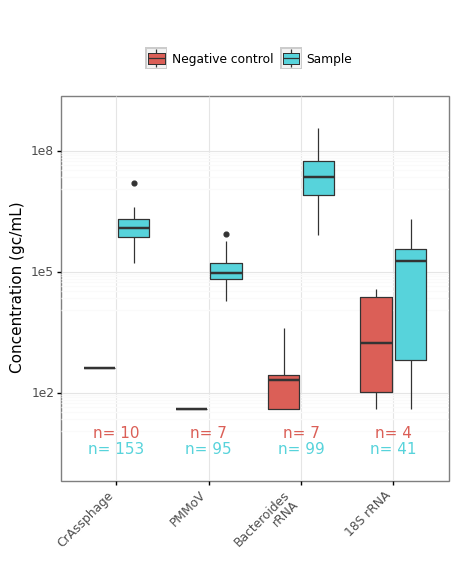

<ggplot: (-9223372036542168639)>

In [11]:
a=qpcr_averaged #[~((qpcr_averaged.replicate == "2")|(qpcr_averaged.replicate == "3")|(qpcr_averaged.replicate == "6")|(qpcr_averaged.replicate == "7")|(qpcr_averaged.replicate == "4"))]

# a.loc[a.blod_master_curve== True, "Quantity_mean"]=0.1
a.loc[a.Sample.str.contains("control"),"Task"]="Negative control"
a.loc[a.Task == "Unknown","Task"]="Sample"
# a=a[a.interceptor =="PBS"]
a=a[a.Target!="N1"]
a=a[a.Target!="GFP"]
a=a[a.Target!="bCoV"]
b=[ "B01", "B02", "B03", "B04", "B07","B09", "B14", "B16", "B17", "B18"]
a=a[a.batch.isin(b)]
a["gc_per_mL"]= a.gc_per_L/1000

crAss_name = "CrAssphage"
pmmov_name= "PMMoV"
bact_name="Bacteroides\nrRNA"
S_name= "18S rRNA"

a.loc[a.Target=="crAss", "Target"]= crAss_name
a.loc[a.Target=="PMMoV", "Target"]= pmmov_name
a.loc[a.Target=="bact", "Target"]= bact_name
a.loc[a.Target=="18S", "Target"]= S_name

#set order of facet
targetLabels = [ crAss_name, pmmov_name, bact_name, S_name] #,"18S_per_cap",  "crAss", "PMMoV", "18S","bact"]
I_catType = CategoricalDtype(categories = targetLabels, ordered = True)
a['Target'] = a['Target'].astype(I_catType)

#add n to the plot
b=a
b['height']= np.nan
a.loc[a.Task=='Sample','height']=4
a.loc[a.Task=='Negative control','height']=10

#get biological triplicate inf
b= b.groupby(["Target","Task"]).agg(height=('height','min'),  n=('gc_per_mL','count')).reset_index()
b['n']='n= '+b['n'].astype('str')

plt = (ggplot() + #Quantity_mean
geom_boxplot(a, aes(x='Target', y='gc_per_mL', fill = "Task"))+
scale_y_log10(expand=(.1,0))+ 
ylab('Concentration (gc/mL)')+
geom_text(aes(x = b.Target, y = b.height, label=b.n, color=b.Task),ha='center', va='center')+
xlab('')+
guides(color = False)+
labs(fill="")+
theme_bw()+ theme(legend_position='top',axis_text_x=element_text(rotation=45, hjust=1), figure_size=(5,5)) )

#title for the plot
n1='Figure_S9' 
plot1=n1  +'.pdf'
#path for the plot
path=os.path.join(dir, plot1)
#save the plot
plt.save(path)


plt


In [12]:
cov= a.groupby(["Target","Task"]).agg(fcc_gstd=('gc_per_L', lambda x: np.nan if ( (len(x.dropna()) <2 )| (x.dropna().sum() == 0)  ) else (sci.gstd(x.dropna(),axis=0))), fcc_gmean= ('gc_per_L', lambda x: sci.gmean(x) ))
cov["gcov"]= cov["fcc_gstd"]-1
cov

fcc_gstd  fcc_gmean     gcov
Target            Task                                          
CrAssphage        Negative control  1.00E+00   4.00E+05 1.78E-15
                  Sample            1.99E+00   1.21E+09 9.85E-01
PMMoV             Negative control  1.00E+00   4.00E+04 0.00E+00
                  Sample            2.04E+00   1.08E+08 1.04E+00
Bacteroides\nrRNA Negative control  5.33E+00   1.69E+05 4.33E+00
                  Sample            4.18E+00   1.93E+10 3.18E+00
18S rRNA          Negative control  3.15E+01   1.45E+06 3.05E+01
                  Sample            4.75E+01   1.84E+07 4.65E+01

add number of PBS controls that amplified to the plot 
* For 18S, 1 PBS control was BLOD --> 3 quantifiable (and 10 samples were undetermined or BLOD)
* PMMoV: 5 PBS controls BLOD --> 0 amplified (put n.d. above box)
* bact: 2 PBS controls BLOD --> 2 quantifiable
* crAss: 10 PBS controls BLOD --> 0 amplified (put n.d. above box)


In [13]:
#boxplot significance 

dfm=a[a.Target == "PMMoV"]
groups="Task"

g=a[groups].unique()

gUknown=dfm.loc[dfm[groups]==g[0],"gc_per_L"]
gPBS=dfm.loc[dfm[groups]==g[1],"gc_per_L"]

data=[gUknown, gPBS]
sci.kruskal(gUknown, gPBS)

#crAss stat different (p <<< 0.05, 1.2e-7)
#18S NOT stat different (p=0.15)
#bact stat different (p < 0.05, 0.0011)
#PMMoV stat different (p < 0.05, 0.00022)


# x=pd.DataFrame(sp.posthoc_dunn(data))
# x.columns=['Unknown', 'PBS']
# x.index=['Unknown', 'PBS']
# x<=0.05 #true means they're statistically different

KruskalResult(statistic=19.375067168189137, pvalue=1.074001335512624e-05)

## Undetermined table

In [14]:
# i=["INF","SQ", "ADA", "S68", "N49"]
# a=qpcr_averaged_merged[qpcr_averaged_merged.interceptor.isin(i)]

# a.groupby(["utility","interceptor","batch","Target"]).agg(n=('date_sampling','count'),  avg_undetermined=('is_undetermined_count','mean'),median_undetermined=('is_undetermined_count','median'), total_undetermined=('is_undetermined_count','sum'))

#create summary table of those that did not amplify 
i=["GFP","bCoV"]
j=[ "B01","B02", "B03", "B04", "B07","B09", "B14", "B16", "B17", "B18"]
a=qpcr_averaged_merged[~qpcr_averaged_merged.Target.isin(i)]
a=a[a.batch.isin(j)]

# a[(a.is_undetermined_count > 1) & (a.Target == "18S")]
undetermined = a.groupby(["Target",]).agg(total_samples=('date_sampling','count'), blod_samples=('blod_master_curve','sum'), )
# undetermined["percent_undetermined_replicates"]= undetermined.total_undetermined_replicates/(undetermined.total_samples*3)
# undetermined["percent_undetermined_replicates"]= undetermined.percent_undetermined_replicates.astype(int)
undetermined

,total_samples,blod_samples
Target,,
18S,41,9
N1,153,52
PMMoV,95,0
bact,99,0
crAss,153,0


In [15]:
#figure out how many samples had N1 but not 18S
no_18S= a.loc[(a.blod_master_curve == True) & (a.Target == "18S"), "Sample"]
a.loc[(a.blod_master_curve == True) & (a.Target == "N1") & (a.Sample.isin(no_18S)), "Sample"]

139    E_Inf_060220_1
148    E_Inf_060420_1
157    E_Inf_061420_1
257    E_Inf_060720_1
620    E_INF_091420_4
Name: Sample, dtype: object

In [16]:
# median concentrations

# conc_18S= a.loc[(a.blod_master_curve == False) & (a.Target == "18S"), "gc_per_L"]
conc_18S= a.loc[(a.Target == "18S"), "gc_per_L"]
conc_18S.median()

185675468.2245884

In [17]:
#same but only with E

#create summary table of those that did not amplify 
i=["GFP","bCoV"]
j=[ "B01","B02", "B03", "B04", "B07","B09", "B14", "B16", "B17", "B18"]
k=["E"]
a=qpcr_averaged_merged[~qpcr_averaged_merged.Target.isin(i)]
a=a[a.utility.isin(k)]
a=a[a.batch.isin(j)]

# a[(a.is_undetermined_count > 1) & (a.Target == "18S")]
undetermined_E = a.groupby(["Target",]).agg(total_samples_E=('date_sampling','count'), blod_samples_E=('blod_master_curve','sum'), )
# undetermined["percent_undetermined_replicates"]= undetermined.total_undetermined_replicates/(undetermined.total_samples*3)
# undetermined["percent_undetermined_replicates"]= undetermined.percent_undetermined_replicates.astype(int)
undetermined_E

,total_samples_E,blod_samples_E
Target,,
18S,17,9
N1,47,28
PMMoV,17,0
bact,17,0
crAss,47,0


## Recovery Controls

In [18]:
qpcr_recovery= qpcr_processed[(qpcr_processed.Target == "bCoV") | (qpcr_processed.Target== "GFP")]
# qpcr_recovery.plate_id.unique()
m= qpcr_recovery[~qpcr_recovery.Sample.str.contains("control")]
qpcr_recovery_medians= m.groupby(["Target"]).agg(Cq_median=('Cq_mean', 'median'), 
                                                 Cq_mean_overall= ('Cq_mean', 'mean'), 
                                                 Cq_min= ('Cq_mean', 'min'),
                                                 Cq_max= ('Cq_mean', 'max'),
                                                 Cq_std= ('Cq_mean', 'std')).reset_index()
qpcr_recovery_medians

,Target,Cq_median,Cq_mean_overall,Cq_min,Cq_max,Cq_std
0,GFP,1.33E+01,1.33E+01,1.22E+01,1.45E+01,5.37E-01
1,bCoV,2.72E+01,2.71E+01,2.54E+01,2.96E+01,1.03E+00


In [19]:
#look for outliers in recovery Ct using grubbs

groupby_list= ["Target"]
plate_df = m
plate_df["Cq"]= m["Cq_mean"]

recovery_grubbs = get_pass_grubbs_test(plate_df, groupby_list)

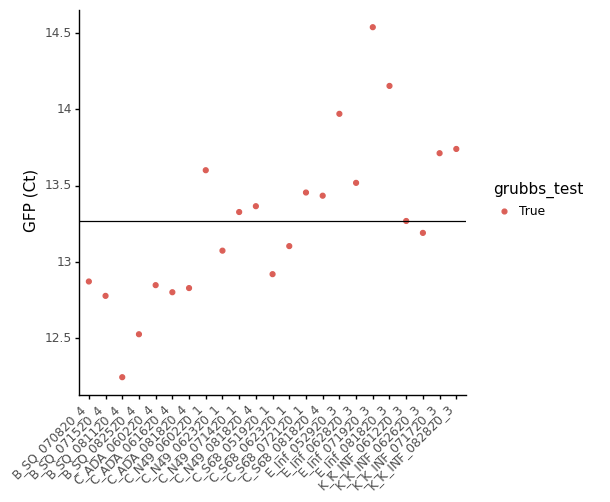

<ggplot: (-9223372036542346450)>

In [20]:
n= recovery_grubbs[recovery_grubbs.Target== "GFP"]
plt = (ggplot(n, aes(x='Sample', y='Cq_mean', color="grubbs_test")) + 
geom_point()+
# geom_smooth(method="loess")+
ylab('GFP (Ct)')+
xlab("")+
# scale_y_log10(expand=(.1,0))+
# facet_wrap('~Target', nrow=2,scales='free_y')+ #, 
geom_hline(n, aes(yintercept=qpcr_recovery_medians.Cq_median[0]))+
# geom_hline(m, aes(yintercept=qpcr_recovery_medians.Cq_median[1]))+
theme_classic()+ theme(axis_text_x=element_text(rotation=45, hjust=1), figure_size=(5,5)) )

plt


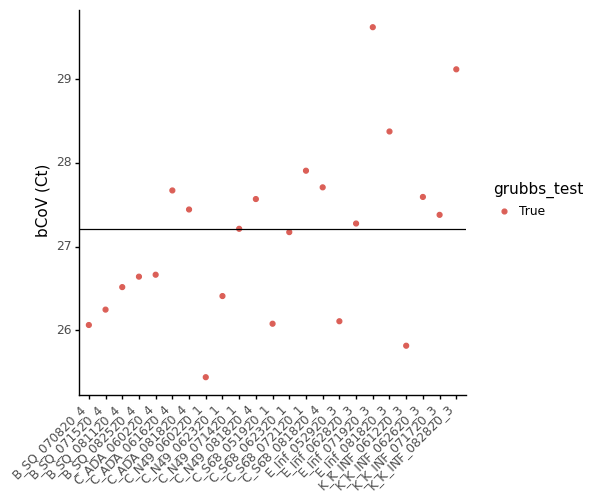

<ggplot: (313633302)>

In [21]:
n= recovery_grubbs[recovery_grubbs.Target== "bCoV"]
plt = (ggplot(n, aes(x='Sample', y='Cq_mean', color= "grubbs_test")) + 
geom_point()+
# geom_smooth(method="loess")+
ylab('bCoV (Ct)')+
xlab("")+
# scale_y_log10(expand=(.1,0))+
# facet_wrap('~Target', nrow=2,scales='free_y')+ #, 
# geom_hline(n, aes(yintercept=qpcr_recovery_medians.Cq_median[0]))+
geom_hline(m, aes(yintercept=qpcr_recovery_medians.Cq_median[1]))+
theme_classic()+ theme(axis_text_x=element_text(rotation=45, hjust=1), figure_size=(5,5)) )

plt

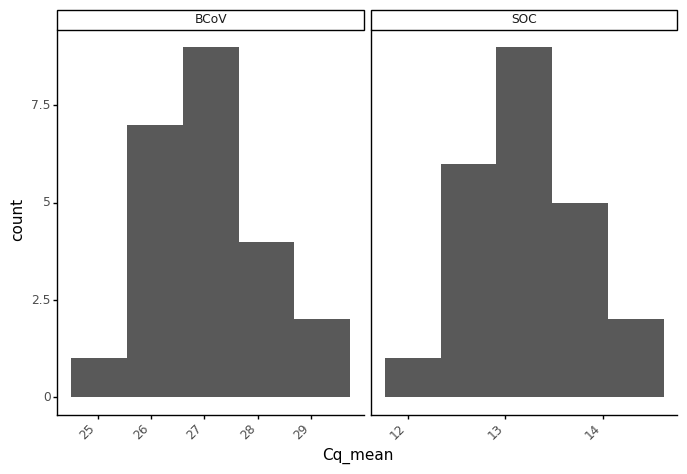

<ggplot: (-9223372036541133529)>

In [22]:
#histograms of Cts for bCoV and GFP
recovery_grubbs.loc[recovery_grubbs.Target== "bCoV", "Target"]= "BCoV"
recovery_grubbs.loc[recovery_grubbs.Target== "GFP", "Target"]= "SOC"

pltA= (ggplot(recovery_grubbs, aes(x='Cq_mean')) + 
       geom_histogram(bins=5)+
       facet_wrap('~Target', ncol=2, scales='free_x')+
       theme_classic()+ theme(axis_text_x=element_text(rotation=45, hjust=1), figure_size=(8,5)) )

pltA
# pltB=(ggplot(recovery_grubbs[recovery_grubbs.Target=="bCoV"], aes(x='Cq_mean')) + 
#        geom_histogram()+
#        theme_classic()+ theme(axis_text_x=element_text(rotation=45, hjust=1), figure_size=(8,5)) )
# pltB

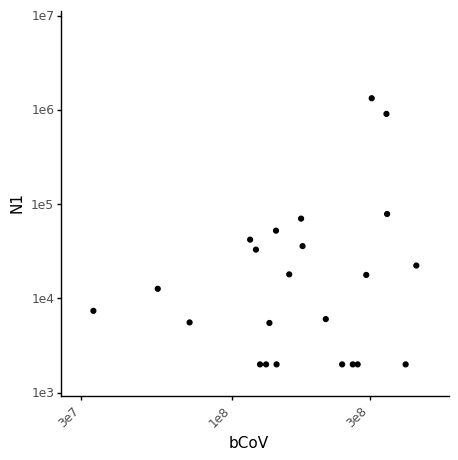

<ggplot: (-9223372036542106501)>

In [23]:
#plot bcov and gfp versus N1 to see if concentrations correlated with recovery

n= qpcr_averaged_merged_wide
plt = (ggplot(n, aes(x='bCoV', y='N1')) + 
geom_point()+
# geom_smooth(method="loess")+
ylab('N1')+
xlab("bCoV")+
scale_y_log10(expand=(.1,0))+
scale_x_log10(expand=(.1,0))+
# facet_wrap('~Target', nrow=2,scales='free_y')+ #, 
# geom_hline(n, aes(yintercept=qpcr_recovery_medians.Cq_median[0]))+
theme_classic()+ theme(axis_text_x=element_text(rotation=45, hjust=1), figure_size=(5,5)) )
plt

# cols_rec= ["N1", "bCoV"]
# df = n[cols_rec]
# df= df.dropna() #(how="any", subset=cols_wfsc)
# [P_r, P_p] = stats.kendalltau(df.N1, df.bCoV)
# P_r, P_p

In [24]:
#plot bcov and gfp versus N1 to see if concentrations correlated with recovery

n= qpcr_averaged_merged_wide
plt = (ggplot(n, aes(x='GFP', y='N1')) + 
geom_point()+
# geom_smooth(method="loess")+
ylab('N1')+
xlab("GFP")+
scale_y_log10(expand=(.1,0))+
scale_x_log10(expand=(.1,0))+
# facet_wrap('~Target', nrow=2,scales='free_y')+ #, 
# geom_hline(n, aes(yintercept=qpcr_recovery_medians.Cq_median[0]))+
theme_classic()+ theme(axis_text_x=element_text(rotation=45, hjust=1), figure_size=(5,5)) )
plt

cols_rec= ["N1", "GFP"]
df = n[cols_rec]
df= df.dropna() #(how="any", subset=cols_wfsc)
[P_r, P_p] = sci.kendalltau(df.N1, df.GFP)
P_r, P_p

(0.10731714116735083, 0.48546390778308)

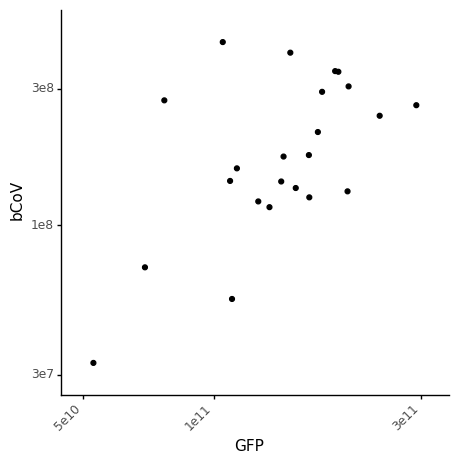

<ggplot: (-9223372036542106543)>

In [25]:
#compare bcov to gfp

n= qpcr_averaged_merged_wide
plt = (ggplot(n, aes(x='GFP', y='bCoV')) + 
geom_point()+
# geom_smooth(method="loess")+
ylab('bCoV')+
xlab("GFP")+
scale_y_log10(expand=(.1,0))+
scale_x_log10(expand=(.1,0))+
# facet_wrap('~Target', nrow=2,scales='free_y')+ #, 
# geom_hline(n, aes(yintercept=qpcr_recovery_medians.Cq_median[0]))+
theme_classic()+ theme(axis_text_x=element_text(rotation=45, hjust=1), figure_size=(5,5)) )
plt

# cols_rec= ["bCoV", "GFP"]
# df = n[cols_rec]
# df= df.dropna() #(how="any", subset=cols_wfsc)
# [P_r, P_p] = stats.kendalltau(df.bCoV, df.GFP)
# P_r, P_p

## Individual standard curves

In [26]:
# s_plates=[109, 97, 110, 102] #these are the plates with long std curves
std_curve_df[std_curve_df.plate_id.isin(plates)]

,plate_id,Target,num_points,Cq_of_lowest_std_quantity,lowest_std_quantity,Cq_of_lowest_std_quantity_gsd,slope,intercept,r2,efficiency,ntc_result,Cq_of_lowest_sample_quantity,intraassay_var
0,6.80E+01,PMMoV,7,3.60E+01,1.00E+02,7.04E-02,-3.46E+00,4.30E+01,1.00E+00,9.45E-01,3.92E+01,3.77E+01,9.77E+00
1,8.50E+01,N1,7,3.79E+01,5.00E+00,1.29E-01,-3.42E+00,4.01E+01,9.98E-01,9.60E-01,negative,3.84E+01,6.55E+01
3,8.60E+01,N1,7,3.72E+01,5.00E+00,7.22E-02,-3.36E+00,3.95E+01,9.96E-01,9.84E-01,negative,3.84E+01,3.91E+01
5,8.70E+01,N1,6,3.75E+01,5.00E+00,6.05E-02,-3.86E+00,4.05E+01,9.95E-01,8.17E-01,negative,3.84E+01,4.57E+01
7,8.80E+01,N1,7,3.70E+01,5.00E+00,6.54E-02,-3.40E+00,3.92E+01,9.99E-01,9.67E-01,negative,3.84E+01,7.43E+01
9,9.10E+01,N1,7,3.82E+01,5.00E+00,9.52E-02,-3.69E+00,4.09E+01,9.98E-01,8.65E-01,negative,3.84E+01,5.04E+01
11,9.20E+01,N1,7,3.74E+01,5.00E+00,9.06E-02,-3.56E+00,3.97E+01,9.92E-01,9.10E-01,negative,3.84E+01,3.09E+01
13,9.30E+01,N1,7,3.84E+01,5.00E+00,9.01E-02,-3.42E+00,4.05E+01,9.84E-01,9.62E-01,negative,3.84E+01,5.47E+01
15,9.40E+01,N1,7,3.84E+01,5.00E+00,6.44E-02,-3.44E+00,4.06E+01,9.97E-01,9.54E-01,negative,3.84E+01,6.12E+01
17,9.50E+01,N1,7,3.61E+01,5.00E+00,9.08E-02,-3.42E+00,3.89E+01,9.98E-01,9.62E-01,negative,3.84E+01,7.73E+01


## Master curves

In [27]:
master_curve

,Target,m,b,LoD_quantity,LoD_Cq,lowest_quantity,lowest_quantity_Cq,highest_quantity,highest_quantity_Cq,efficiency,R2,tLoD_quantity,tLoD_Cq,t_lowest_quantity,t_lowest_quantity_Cq,LoD_gc_per_L
0,N1,-3.48E+00,3.98E+01,2.50E+00,3.84E+01,5,3.73E+01,100000,2.24E+01,9.38E-01,9.86E-01,1.50E+00,3.92E+01,3,3.96E+01,4.00E+03
1,PMMoV,-3.50E+00,4.37E+01,5.00E+01,3.77E+01,100,3.67E+01,100000000,1.57E+01,9.31E-01,9.95E-01,1.50E+00,4.30E+01,3,6.16E+01,8.00E+04
2,crAss,-3.56E+00,4.39E+01,5.00E+02,3.42E+01,1000,3.32E+01,1000000000,1.18E+01,9.09E-01,9.96E-01,1.50E+00,4.32E+01,3,2.73E+02,8.00E+05
3,bact,-3.65E+00,4.37E+01,5.00E+01,3.75E+01,100,3.64E+01,200000000,1.34E+01,8.78E-01,9.85E-01,1.50E+00,4.30E+01,3,6.13E+01,8.00E+04
4,18S,-3.76E+00,4.35E+01,5.00E+01,3.71E+01,100,3.60E+01,100000000,1.34E+01,8.45E-01,9.89E-01,1.50E+00,4.28E+01,3,6.10E+01,8.00E+04
5,GFP,-3.52E+00,4.20E+01,5.00E+03,2.90E+01,10000,2.80E+01,10000000000,6.85E+00,9.24E-01,9.97E-01,1.50E+00,4.14E+01,3,2.41E+03,8.00E+06
6,bCoV,-3.83E+00,4.73E+01,5.00E+01,4.08E+01,100,3.96E+01,100000000,1.66E+01,8.24E-01,9.96E-01,1.50E+00,4.66E+01,3,6.46E+01,8.00E+04


# Individual location df manipulation

In [28]:
import datetime #needs to go here for time delta to work
#unique number of dates to expect for each interceptor
pK=13
pE=19
pSQ=10
pS=20
pA=11
pN=18

lw=1
people=1000 #case data out of how many people
case_LoD=11/7
case_LoD_N=11/14
case_LoD_sq=1/7

name_N1C_int= "N1 (gc/mL) normalized to median normalized crAss by location\nwhere Lowess alpha= {}\n"
name_N1C="N1 (gc/mL) normalized to median normalized crAss by location"
name_N1Cr_int= "N1 / crAssphage (unitless)\nwhere Lowess alpha= {}\n"
name_N1Cr="N1 / crAssphage (unitless)"
name_N1_int="N1 (gc/mL)\nwhere Lowess alpha= {}\n"
name_N1_flow="N1 (gc/person/day)\nwhere Lowess alpha= {}\n"
name_N1= "N1 (gc/mL)"
name_new_cases="New cases per day unnormalized\nwhere model is seven-day moving average\n"
name_active_cases="Active cases per day unnormalized\nwhere model is seven-day moving average\n"
name_new_cases_norm="Daily new cases per 1000 people"
name_active_cases_norm="Daily active cases per 1000 people"
legend_N1_und= "Number of wastewater N1\nqPCR technical replicates that did not amplify"
name_alpha="Bandwidth\nfraction of series\nused for smoothing\n"

#cross correlation stat
meth='kendall' #can be kendall, pearson, or spearman
name_cross_meth= "Kendall Tau value"
end_lag_days= 15 
extension_days= datetime.timedelta(days=14)
name_cross_days="Offset shifting wastewater data forward (days)"


name_N1C_int= "N1 normalized to median normalized crAssphage\nwhere model is lowess alpha= {}\n"
name_N1P_int= "N1 normalized to median normalized PMMoV\nwhere model is lowess alpha= {}\n"
name_N1S_int= "N1 normalized to median normalized 18S\nwhere model is lowess alpha= {}\n"
name_N1b_int= "N1 normalized to median normalized Bacteroides rRNA\nwhere model is lowess alpha= {}\n"
name_N1Fa_int= "N1 gc/person/day\nwhere model is lowess alpha= {}\n"
name_N1_int="N1 gc/mL\nwhere model is lowess alpha= {}\n"
name_new_cases="new cases per day unnormalized\nwhere model is seven day moving average\n"
name_active_cases="active cases per day unnormalized\nwhere model is seven day moving average\n"

name_N1C= "N1 normalized to median normalized\ncrAssphage model"
name_N1P= "N1 normalized to median normalized\nPMMoV model"
name_N1S= "N1 normalized to median normalized\n18S model"
name_N1b= "N1 normalized to median normalized\nBacteroides model"
name_N1Fa= "N1 gc/person/day model"
name_N1="N1 gc/mL model "

#color formatting
ada_c="#453781"
s68_c="#287D8E"
n49_c= "#3CBB75"
k_c="#C0369D"
sq_c="#DCE319"
e_c= "#8F40AD"

#font sizes
ftl=9.5
fts=8

## Location K

In [29]:
code="K_K_INF"
a=qpcr_loess_dict[code]


a.points=pd.to_numeric(a.points)
a['alpha_v']=a.points/(pK)
a['alpha_rounded']=a.alpha_v.apply(lambda x: round(x,2) ).astype(object) 
lis=["N1", "N1_crAss_reg"]
a=a[a.Target.isin(lis)].copy()

a.loc[a.Target=="N1_crAss", "Target"]= name_N1C
a.loc[a.Target=="N1_crAss_reg", "Target"]= name_N1Cr
a.loc[a.Target=="N1", "Target"]= name_N1

#choosing points
pts_N1=6
pts_N1C=7
pts_N1Cr=7
alpha_N1=pd.to_numeric(a.loc[a.points==pts_N1, "alpha_v"].unique().item())
alpha_N1C=pd.to_numeric(a.loc[a.points==pts_N1C, "alpha_v"].unique().item())
alpha_N1Cr=pd.to_numeric(a.loc[a.points==pts_N1Cr, "alpha_v"].unique().item())



In [30]:

loess=qpcr_loess_dict[code].copy()

loess_N1=loess[loess.Target=="N1"].copy()
loess_N1["Target"]="N1_int"
loess_N1_int= loess_N1.loc[loess_N1.alpha_v==alpha_N1,].copy().set_index("date_sampling").drop(["points", "alpha_v", "residuals", "Target", "alpha_rounded"], axis=1)
loess_N1_int=loess_N1_int.resample('D').max() #max just places nans because adding dates not subtracting
loess_N1_int["y_pred_int"]=loess_N1_int["y_pred"].interpolate(method='linear')


loess_N1C=loess[loess.Target=="N1_crAss"].copy()
loess_N1C["Target"]="N1C_int"
loess_N1C_int= loess_N1C.loc[loess_N1C.alpha_v==alpha_N1C,].copy().set_index("date_sampling").drop(["points", "alpha_v", "residuals", "Target", "alpha_rounded"], axis=1)
loess_N1C_int=loess_N1C_int.resample('D').max() #max just places nans because adding dates not subtracting
loess_N1C_int["y_pred_int"]=loess_N1C_int["y_pred"].interpolate(method='linear')

loess_N1Cr=loess[loess.Target=="N1_crAss_reg"].copy()
loess_N1Cr["Target"]="N1Cr_int"
loess_N1Cr_int= loess_N1Cr.loc[loess_N1Cr.alpha_v==alpha_N1Cr,].copy().set_index("date_sampling").drop(["points", "alpha_v", "residuals", "Target", "alpha_rounded"], axis=1)
loess_N1Cr_int=loess_N1Cr_int.resample('D').max() #max just places nans because adding dates not subtracting
loess_N1Cr_int["y_pred_int"]=loess_N1Cr_int["y_pred"].interpolate(method='linear')

loess_N1=loess_N1.reset_index(drop=True)
loess_N1C=loess_N1C.reset_index(drop=True)
loess_N1Cr=loess_N1Cr.reset_index(drop=True)
pt=loess_N1.alpha_v.unique()


#merge lowess and case data models to create a dataframe of models
case_model_lookup=qpcr_int[qpcr_int.sample_code==code][["date_sampling","moving_average_new_cases", "moving_average_active_cases","population", "average_flow_MGD"]].copy()
case_model_lookup["mvga_7D_new_cases"]= case_model_lookup["moving_average_new_cases"]
case_model_lookup["mvga_7D_active_cases"]= case_model_lookup["moving_average_active_cases"]
case_model_lookup["mvga_7D_new_cases_norm"]= case_model_lookup["mvga_7D_new_cases"] / case_model_lookup["population"]
case_model_lookup["mvga_7D_active_cases_norm"]= case_model_lookup["mvga_7D_active_cases"] / case_model_lookup["population"]
case_model_lookup=case_model_lookup.copy().drop(["moving_average_new_cases", "moving_average_active_cases"], axis=1)

models_merge= loess_N1C_int.copy().reset_index().drop(["y_pred" ],axis=1)
models_merge.columns=["date_sampling", "N1C_int"]

models_merge2= loess_N1Cr_int.copy().reset_index().drop(["y_pred" ],axis=1)
models_merge2.columns=["date_sampling", "N1Cr_int"]

models_int=loess_N1_int.reset_index().merge(case_model_lookup, how='outer', on='date_sampling')
models_int=models_int.drop("y_pred", axis=1)
models_int.columns=["date_sampling","N1_int", "population", "average_flow_MGD", "new_cases", "active_cases", "new_cases_per_capita", "active_cases_per_capita"]
models_int=models_int.merge(models_merge, how='left', on='date_sampling')
models_int=models_int.merge(models_merge2, how='left', on='date_sampling')

# models_int_long=models_int.copy().melt(id_vars="date_sampling", value_vars=["N1_int", "new_cases", "active_cases","N1C_int"], var_name="Target", value_name="model")
models_int_long=models_int.copy().melt(id_vars="date_sampling", value_vars=["N1_int", "new_cases_per_capita", "active_cases_per_capita","N1C_int", "N1Cr_int"], var_name="Target", value_name="model")


In [31]:
a=qpcr_long_dict[code].copy()
a=a[~np.isnan(a.value)]
a=a[(a.date_sampling >= start_dict[code]) & (a.date_sampling <= end_dict[code])]

a=a.merge(models_int_long, how='left', on=["date_sampling", "Target"])
a.loc[a.Target== "N1_int", "value"]= a.loc[a.Target== "N1_int", "value"]/1000 #convert to gc/mL
a.loc[a.Target== "N1C_int", "value"]= a.loc[a.Target== "N1C_int", "value"]/1000 #convert to same om as above ONLY when normalized to the median
a.loc[a.Target== "N1Fa_int", "value"]= a.loc[a.Target== "N1Fa_int", "value"]/1000 #convert to same om as above ONLY when normalized to the median
a.loc[a.Target== "N1P_int", "value"]= a.loc[a.Target== "N1P_int", "value"]/1000 #convert to same om as above ONLY when normalized to the median
a.loc[a.Target== "N1b_int", "value"]= a.loc[a.Target== "N1b_int", "value"]/1000 #convert to same om as above ONLY when normalized to the median
a.loc[a.Target== "N1S_int", "value"]= a.loc[a.Target== "N1S_int", "value"]/1000 #convert to same om as above ONLY when normalized to the median
a.loc[a.Target== "N1_int", "model"]= a.loc[a.Target== "N1_int", "model"]/1000 #convert to gc/mL
a.loc[a.Target== "N1C_int", "model"]= a.loc[a.Target== "N1C_int", "model"]/1000 #convert to same om as above ONLY when normalized to the median
a.loc[a.Target== "N1Fa_int", "model"]= a.loc[a.Target== "N1Fa_int", "model"]/1000 #convert to same om as above ONLY when normalized to the median
a.loc[a.Target== "N1P_int", "model"]= a.loc[a.Target== "N1P_int", "model"]/1000 #convert to same om as above ONLY when normalized to the median
a.loc[a.Target== "N1b_int", "model"]= a.loc[a.Target== "N1b_int", "model"]/1000 #convert to same om as above ONLY when normalized to the median
a.loc[a.Target== "N1S_int", "model"]= a.loc[a.Target== "N1S_int", "model"]/1000 #convert to same om as above ONLY when normalized to the median

t=["N1Fa_int", "N1C_int","N1_int","N1P_int", "N1b_int", "N1S_int", "new_cases"]
a=a[a.Target.isin(t)]
a["Target_p"]=a.Target
a.loc[a.Target=="N1C_int", "Target"]= name_N1C_int.format(round(alpha_N1,2))
a.loc[a.Target=="N1_int", "Target"]= name_N1_int.format(round(alpha_N1,2))
a.loc[a.Target=="new_cases", "Target"]= name_new_cases
a.loc[a.Target=="N1Fa_int", "Target"]= name_N1Fa_int.format(round(alpha_N1,2))
a.loc[a.Target=="N1P_int", "Target"]= name_N1P_int.format(round(alpha_N1,2))
a.loc[a.Target=="N1b_int", "Target"]= name_N1b_int.format(round(alpha_N1,2))
a.loc[a.Target=="N1S_int", "Target"]= name_N1S_int.format(round(alpha_N1,2))


a['ymax']=a.value * a.gstd
a['ymin']=a.value / a.gstd

K=a.copy()
K["location"]="K"




## Location Q

In [32]:
code="B_B_SQ"
a=qpcr_loess_dict[code]

a.points=pd.to_numeric(a.points)
a['alpha_v']=a.points/(pSQ)
a['alpha_rounded']=a.alpha_v.apply(lambda x: round(x,2) ).astype(object)
lis=["N1", "N1_crAss_reg"]
a=a[a.Target.isin(lis)].copy()

a.loc[a.Target=="N1_crAss", "Target"]= name_N1C
a.loc[a.Target=="N1_crAss_reg", "Target"]= name_N1Cr
a.loc[a.Target=="N1", "Target"]= name_N1

#choosing points
pts_N1=6
pts_N1C=5
pts_N1Cr=5
alpha_N1=pd.to_numeric(a.loc[a.points==pts_N1, "alpha_v"].unique().item())
alpha_N1C=pd.to_numeric(a.loc[a.points==pts_N1C, "alpha_v"].unique().item())
alpha_N1Cr=pd.to_numeric(a.loc[a.points==pts_N1Cr, "alpha_v"].unique().item())



In [33]:
 
loess=qpcr_loess_dict[code].copy()

loess_N1=loess[loess.Target=="N1"].copy()
loess_N1["Target"]="N1_int"
loess_N1_int= loess_N1.loc[loess_N1.alpha_v==alpha_N1,].copy().set_index("date_sampling").drop(["points", "alpha_v", "residuals", "Target", "alpha_rounded"], axis=1)
loess_N1_int=loess_N1_int.resample('D').max() #max just places nans because adding dates not subtracting
loess_N1_int["y_pred_int"]=loess_N1_int["y_pred"].interpolate(method='linear')


loess_N1C=loess[loess.Target=="N1_crAss"].copy()
loess_N1C["Target"]="N1C_int"
loess_N1C_int= loess_N1C.loc[loess_N1C.alpha_v==alpha_N1C,].copy().set_index("date_sampling").drop(["points", "alpha_v", "residuals", "Target", "alpha_rounded"], axis=1)
loess_N1C_int=loess_N1C_int.resample('D').max() #max just places nans because adding dates not subtracting
loess_N1C_int["y_pred_int"]=loess_N1C_int["y_pred"].interpolate(method='linear')

loess_N1Cr=loess[loess.Target=="N1_crAss_reg"].copy()
loess_N1Cr["Target"]="N1Cr_int"
loess_N1Cr_int= loess_N1Cr.loc[loess_N1Cr.alpha_v==alpha_N1Cr,].copy().set_index("date_sampling").drop(["points", "alpha_v", "residuals", "Target", "alpha_rounded"], axis=1)
loess_N1Cr_int=loess_N1Cr_int.resample('D').max() #max just places nans because adding dates not subtracting
loess_N1Cr_int["y_pred_int"]=loess_N1Cr_int["y_pred"].interpolate(method='linear')

loess_N1=loess_N1.reset_index(drop=True)
loess_N1C=loess_N1C.reset_index(drop=True)
loess_N1Cr=loess_N1Cr.reset_index(drop=True)
pt=loess_N1.alpha_v.unique()


#merge lowess and case data models to create a dataframe of models
case_model_lookup=qpcr_int[qpcr_int.sample_code==code][["date_sampling","moving_average_new_cases", "moving_average_active_cases","population", "average_flow_MGD"]].copy()
case_model_lookup["mvga_7D_new_cases"]= case_model_lookup["moving_average_new_cases"]
case_model_lookup["mvga_7D_active_cases"]= case_model_lookup["moving_average_active_cases"]
case_model_lookup["mvga_7D_new_cases_norm"]= case_model_lookup["mvga_7D_new_cases"] / case_model_lookup["population"]
case_model_lookup["mvga_7D_active_cases_norm"]= case_model_lookup["mvga_7D_active_cases"] / case_model_lookup["population"]
case_model_lookup=case_model_lookup.copy().drop(["moving_average_new_cases", "moving_average_active_cases"], axis=1)

models_merge= loess_N1C_int.copy().reset_index().drop(["y_pred" ],axis=1)
models_merge.columns=["date_sampling", "N1C_int"]

models_merge2= loess_N1Cr_int.copy().reset_index().drop(["y_pred" ],axis=1)
models_merge2.columns=["date_sampling", "N1Cr_int"]

models_int=loess_N1_int.reset_index().merge(case_model_lookup, how='outer', on='date_sampling')
models_int=models_int.drop("y_pred", axis=1)
models_int.columns=["date_sampling","N1_int", "population", "average_flow_MGD", "new_cases", "active_cases", "new_cases_per_capita", "active_cases_per_capita"]
models_int=models_int.merge(models_merge, how='left', on='date_sampling')
models_int=models_int.merge(models_merge2, how='left', on='date_sampling')

# models_int_long=models_int.copy().melt(id_vars="date_sampling", value_vars=["N1_int", "new_cases", "active_cases","N1C_int"], var_name="Target", value_name="model")
models_int_long=models_int.copy().melt(id_vars="date_sampling", value_vars=["N1_int", "new_cases_per_capita", "active_cases_per_capita","N1C_int", "N1Cr_int"], var_name="Target", value_name="model")


In [34]:
a=qpcr_long_dict[code].copy()
a=a[~np.isnan(a.value)]
a=a[(a.date_sampling >= start_dict[code]) & (a.date_sampling <= end_dict[code])]

a=a.merge(models_int_long, how='left', on=["date_sampling", "Target"])
a.loc[a.Target== "N1_int", "value"]= a.loc[a.Target== "N1_int", "value"]/1000 #convert to gc/mL
a.loc[a.Target== "N1C_int", "value"]= a.loc[a.Target== "N1C_int", "value"]/1000 #convert to same om as above ONLY when normalized to the median
a.loc[a.Target== "N1Fa_int", "value"]= a.loc[a.Target== "N1Fa_int", "value"]/1000 #convert to same om as above ONLY when normalized to the median
a.loc[a.Target== "N1P_int", "value"]= a.loc[a.Target== "N1P_int", "value"]/1000 #convert to same om as above ONLY when normalized to the median
a.loc[a.Target== "N1b_int", "value"]= a.loc[a.Target== "N1b_int", "value"]/1000 #convert to same om as above ONLY when normalized to the median
a.loc[a.Target== "N1S_int", "value"]= a.loc[a.Target== "N1S_int", "value"]/1000 #convert to same om as above ONLY when normalized to the median
a.loc[a.Target== "N1_int", "model"]= a.loc[a.Target== "N1_int", "model"]/1000 #convert to gc/mL
a.loc[a.Target== "N1C_int", "model"]= a.loc[a.Target== "N1C_int", "model"]/1000 #convert to same om as above ONLY when normalized to the median
a.loc[a.Target== "N1Fa_int", "model"]= a.loc[a.Target== "N1Fa_int", "model"]/1000 #convert to same om as above ONLY when normalized to the median
a.loc[a.Target== "N1P_int", "model"]= a.loc[a.Target== "N1P_int", "model"]/1000 #convert to same om as above ONLY when normalized to the median
a.loc[a.Target== "N1b_int", "model"]= a.loc[a.Target== "N1b_int", "model"]/1000 #convert to same om as above ONLY when normalized to the median
a.loc[a.Target== "N1S_int", "model"]= a.loc[a.Target== "N1S_int", "model"]/1000 #convert to same om as above ONLY when normalized to the median

t=["N1Fa_int", "N1C_int","N1_int","N1P_int", "N1b_int", "N1S_int", "new_cases"]
a=a[a.Target.isin(t)]
a["Target_p"]=a.Target
a.loc[a.Target=="N1C_int", "Target"]= name_N1C_int.format(round(alpha_N1,2))
a.loc[a.Target=="N1_int", "Target"]= name_N1_int.format(round(alpha_N1,2))
a.loc[a.Target=="new_cases", "Target"]= name_new_cases
a.loc[a.Target=="N1Fa_int", "Target"]= name_N1Fa_int
a.loc[a.Target=="N1P_int", "Target"]= name_N1P_int
a.loc[a.Target=="N1b_int", "Target"]= name_N1b_int
a.loc[a.Target=="N1S_int", "Target"]= name_N1S_int


a['ymax']=a.value * a.gstd
a['ymin']=a.value / a.gstd

SQ=a.copy()
SQ["location"]="SQ"


## Location S

In [35]:
code="C_C_S68"
a=qpcr_loess_dict[code]

a.points=pd.to_numeric(a.points)
a['alpha_v']=a.points/(pS)
a['alpha_rounded']=a.alpha_v.apply(lambda x: round(x,2) ).astype(object)
lis=["N1", "N1_crAss", "N1_crAss_reg"]
lis=["N1", "N1_crAss_reg"]
a=a[a.Target.isin(lis)].copy()

a.loc[a.Target=="N1_crAss", "Target"]= name_N1C
a.loc[a.Target=="N1_crAss_reg", "Target"]= name_N1Cr
a.loc[a.Target=="N1", "Target"]= name_N1

b=a
b=b[b.Target==name_N1Cr]

alp=[0.05,0.25, 0.4,0.6, 0.8,1]
b=b[b.alpha_rounded.isin(alp)]


In [36]:

loess=qpcr_loess_dict[code].copy()

loess_N1=loess[loess.Target=="N1"].copy()
loess_N1["Target"]="N1_int"
loess_N1_int= loess_N1.loc[loess_N1.alpha_v==alpha_N1,].copy().set_index("date_sampling").drop(["points", "alpha_v", "residuals", "Target", "alpha_rounded"], axis=1)
loess_N1_int=loess_N1_int.resample('D').max() #max just places nans because adding dates not subtracting
loess_N1_int["y_pred_int"]=loess_N1_int["y_pred"].interpolate(method='linear')


loess_N1C=loess[loess.Target=="N1_crAss"].copy()
loess_N1C["Target"]="N1C_int"
loess_N1C_int= loess_N1C.loc[loess_N1C.alpha_v==alpha_N1C,].copy().set_index("date_sampling").drop(["points", "alpha_v", "residuals", "Target", "alpha_rounded"], axis=1)
loess_N1C_int=loess_N1C_int.resample('D').max() #max just places nans because adding dates not subtracting
loess_N1C_int["y_pred_int"]=loess_N1C_int["y_pred"].interpolate(method='linear')

loess_N1Cr=loess[loess.Target=="N1_crAss_reg"].copy()
loess_N1Cr["Target"]="N1Cr_int"
loess_N1Cr_int= loess_N1Cr.loc[loess_N1Cr.alpha_v==alpha_N1Cr,].copy().set_index("date_sampling").drop(["points", "alpha_v", "residuals", "Target", "alpha_rounded"], axis=1)
loess_N1Cr_int=loess_N1Cr_int.resample('D').max() #max just places nans because adding dates not subtracting
loess_N1Cr_int["y_pred_int"]=loess_N1Cr_int["y_pred"].interpolate(method='linear')

loess_N1=loess_N1.reset_index(drop=True)
loess_N1C=loess_N1C.reset_index(drop=True)
loess_N1Cr=loess_N1Cr.reset_index(drop=True)
pt=loess_N1.alpha_v.unique()


#merge lowess and case data models to create a dataframe of models
case_model_lookup=qpcr_int[qpcr_int.sample_code==code][["date_sampling","moving_average_new_cases", "moving_average_active_cases","population", "average_flow_MGD"]].copy()
case_model_lookup["mvga_7D_new_cases"]= case_model_lookup["moving_average_new_cases"]
case_model_lookup["mvga_7D_active_cases"]= case_model_lookup["moving_average_active_cases"]
case_model_lookup["mvga_7D_new_cases_norm"]= case_model_lookup["mvga_7D_new_cases"] / case_model_lookup["population"]
case_model_lookup["mvga_7D_active_cases_norm"]= case_model_lookup["mvga_7D_active_cases"] / case_model_lookup["population"]
case_model_lookup=case_model_lookup.copy().drop(["moving_average_new_cases", "moving_average_active_cases"], axis=1)

models_merge= loess_N1C_int.copy().reset_index().drop(["y_pred" ],axis=1)
models_merge.columns=["date_sampling", "N1C_int"]

models_merge2= loess_N1Cr_int.copy().reset_index().drop(["y_pred" ],axis=1)
models_merge2.columns=["date_sampling", "N1Cr_int"]

models_int=loess_N1_int.reset_index().merge(case_model_lookup, how='outer', on='date_sampling')
models_int=models_int.drop("y_pred", axis=1)
models_int.columns=["date_sampling","N1_int", "population", "average_flow_MGD", "new_cases", "active_cases", "new_cases_per_capita", "active_cases_per_capita"]
models_int=models_int.merge(models_merge, how='left', on='date_sampling')
models_int=models_int.merge(models_merge2, how='left', on='date_sampling')

# models_int_long=models_int.copy().melt(id_vars="date_sampling", value_vars=["N1_int", "new_cases", "active_cases","N1C_int"], var_name="Target", value_name="model")
models_int_long=models_int.copy().melt(id_vars="date_sampling", value_vars=["N1_int", "new_cases_per_capita", "active_cases_per_capita","N1C_int", "N1Cr_int"], var_name="Target", value_name="model")


In [37]:
a=qpcr_long_dict[code].copy()
a=a[~np.isnan(a.value)]
a=a[(a.date_sampling >= start_dict[code]) & (a.date_sampling <= end_dict[code])]
models_int_long.date_sampling=pd.to_datetime(models_int_long.date_sampling)
a=a.merge(models_int_long, how='left', on=["date_sampling", "Target"])
a.loc[a.Target== "N1_int", "value"]= a.loc[a.Target== "N1_int", "value"]/1000 #convert to gc/mL
a.loc[a.Target== "N1C_int", "value"]= a.loc[a.Target== "N1C_int", "value"]/1000 #convert to same om as above ONLY when normalized to the median
a.loc[a.Target== "N1P_int", "value"]= a.loc[a.Target== "N1P_int", "value"]/1000 #convert to same om as above ONLY when normalized to the median
a.loc[a.Target== "N1b_int", "value"]= a.loc[a.Target== "N1b_int", "value"]/1000 #convert to same om as above ONLY when normalized to the median
a.loc[a.Target== "N1_int", "model"]= a.loc[a.Target== "N1_int", "model"]/1000 #convert to gc/mL
a.loc[a.Target== "N1C_int", "model"]= a.loc[a.Target== "N1C_int", "model"]/1000 #convert to same om as above ONLY when normalized to the median
a.loc[a.Target== "N1P_int", "model"]= a.loc[a.Target== "N1P_int", "model"]/1000 #convert to same om as above ONLY when normalized to the median
a.loc[a.Target== "N1b_int", "model"]= a.loc[a.Target== "N1b_int", "model"]/1000 #convert to same om as above ONLY when normalized to the median

t=[ "N1C_int","N1_int","N1P_int", "N1b_int",  "new_cases"]
a=a[a.Target.isin(t)]
a["Target_p"]=a.Target
a.loc[a.Target=="N1C_int", "Target"]= name_N1C_int.format(round(alpha_N1,2))
a.loc[a.Target=="N1_int", "Target"]= name_N1_int.format(round(alpha_N1,2))
a.loc[a.Target=="new_cases", "Target"]= name_new_cases
a.loc[a.Target=="N1P_int", "Target"]= name_N1P_int.format(round(alpha_N1,2))
a.loc[a.Target=="N1b_int", "Target"]= name_N1b_int.format(round(alpha_N1,2))


a['ymax']=a.value * a.gstd
a['ymin']=a.value / a.gstd

S=a.copy()
S["location"]="S68"



## Location N

In [38]:
code="C_C_N49"
a=qpcr_loess_dict[code]

a.points=pd.to_numeric(a.points)
a['alpha_v']=a.points/(pN)
a['alpha_rounded']=a.alpha_v.apply(lambda x: round(x,2) ).astype(object)
lis=["N1", "N1_crAss_reg"]
a=a[a.Target.isin(lis)].copy()

a.loc[a.Target=="N1_crAss", "Target"]= name_N1C
a.loc[a.Target=="N1_crAss_reg", "Target"]= name_N1Cr
a.loc[a.Target=="N1", "Target"]= name_N1

#choosing points
pts_N1=7
pts_N1C=6
pts_N1Cr=6
alpha_N1=pd.to_numeric(a.loc[a.points==pts_N1, "alpha_v"].unique().item())
alpha_N1C=pd.to_numeric(a.loc[a.points==pts_N1C, "alpha_v"].unique().item())
alpha_N1Cr=pd.to_numeric(a.loc[a.points==pts_N1Cr, "alpha_v"].unique().item())

In [39]:

loess=qpcr_loess_dict[code].copy()

loess_N1=loess[loess.Target=="N1"].copy()
loess_N1["Target"]="N1_int"
loess_N1_int= loess_N1.loc[loess_N1.alpha_v==alpha_N1,].copy().set_index("date_sampling").drop(["points", "alpha_v", "residuals", "Target", "alpha_rounded"], axis=1)
loess_N1_int=loess_N1_int.resample('D').max() #max just places nans because adding dates not subtracting
loess_N1_int["y_pred_int"]=loess_N1_int["y_pred"].interpolate(method='linear')


loess_N1C=loess[loess.Target=="N1_crAss"].copy()
loess_N1C["Target"]="N1C_int"
loess_N1C_int= loess_N1C.loc[loess_N1C.alpha_v==alpha_N1C,].copy().set_index("date_sampling").drop(["points", "alpha_v", "residuals", "Target", "alpha_rounded"], axis=1)
loess_N1C_int=loess_N1C_int.resample('D').max() #max just places nans because adding dates not subtracting
loess_N1C_int["y_pred_int"]=loess_N1C_int["y_pred"].interpolate(method='linear')

loess_N1Cr=loess[loess.Target=="N1_crAss_reg"].copy()
loess_N1Cr["Target"]="N1Cr_int"
loess_N1Cr_int= loess_N1Cr.loc[loess_N1Cr.alpha_v==alpha_N1Cr,].copy().set_index("date_sampling").drop(["points", "alpha_v", "residuals", "Target", "alpha_rounded"], axis=1)
loess_N1Cr_int=loess_N1Cr_int.resample('D').max() #max just places nans because adding dates not subtracting
loess_N1Cr_int["y_pred_int"]=loess_N1Cr_int["y_pred"].interpolate(method='linear')

loess_N1=loess_N1.reset_index(drop=True)
loess_N1C=loess_N1C.reset_index(drop=True)
loess_N1Cr=loess_N1Cr.reset_index(drop=True)
pt=loess_N1.alpha_v.unique()


#merge lowess and case data models to create a dataframe of models
case_model_lookup=qpcr_int[qpcr_int.sample_code==code][["date_sampling","moving_average_new_cases", "moving_average_active_cases","population", "average_flow_MGD"]].copy()
case_model_lookup["mvga_7D_new_cases"]= case_model_lookup["moving_average_new_cases"]
case_model_lookup["mvga_7D_active_cases"]= case_model_lookup["moving_average_active_cases"]
case_model_lookup["mvga_7D_new_cases_norm"]= case_model_lookup["mvga_7D_new_cases"] / case_model_lookup["population"]
case_model_lookup["mvga_7D_active_cases_norm"]= case_model_lookup["mvga_7D_active_cases"] / case_model_lookup["population"]
case_model_lookup=case_model_lookup.copy().drop(["moving_average_new_cases", "moving_average_active_cases"], axis=1)

models_merge= loess_N1C_int.copy().reset_index().drop(["y_pred" ],axis=1)
models_merge.columns=["date_sampling", "N1C_int"]

models_merge2= loess_N1Cr_int.copy().reset_index().drop(["y_pred" ],axis=1)
models_merge2.columns=["date_sampling", "N1Cr_int"]

models_int=loess_N1_int.reset_index().merge(case_model_lookup, how='outer', on='date_sampling')
models_int=models_int.drop("y_pred", axis=1)
models_int.columns=["date_sampling","N1_int", "population", "average_flow_MGD", "new_cases", "active_cases", "new_cases_per_capita", "active_cases_per_capita"]
models_int=models_int.merge(models_merge, how='left', on='date_sampling')
models_int=models_int.merge(models_merge2, how='left', on='date_sampling')

# models_int_long=models_int.copy().melt(id_vars="date_sampling", value_vars=["N1_int", "new_cases", "active_cases","N1C_int"], var_name="Target", value_name="model")
models_int_long=models_int.copy().melt(id_vars="date_sampling", value_vars=["N1_int", "new_cases_per_capita", "active_cases_per_capita","N1C_int", "N1Cr_int"], var_name="Target", value_name="model")


In [40]:
a=qpcr_long_dict[code].copy()
a=a[~np.isnan(a.value)]
a=a[(a.date_sampling >= start_dict[code]) & (a.date_sampling <= end_dict[code])]

a=a.merge(models_int_long, how='left', on=["date_sampling", "Target"])
a.loc[a.Target== "N1_int", "value"]= a.loc[a.Target== "N1_int", "value"]/1000 #convert to gc/mL
a.loc[a.Target== "N1C_int", "value"]= a.loc[a.Target== "N1C_int", "value"]/1000 #convert to same om as above ONLY when normalized to the median
a.loc[a.Target== "N1P_int", "value"]= a.loc[a.Target== "N1P_int", "value"]/1000 #convert to same om as above ONLY when normalized to the median
a.loc[a.Target== "N1b_int", "value"]= a.loc[a.Target== "N1b_int", "value"]/1000 #convert to same om as above ONLY when normalized to the median
a.loc[a.Target== "N1_int", "model"]= a.loc[a.Target== "N1_int", "model"]/1000 #convert to gc/mL
a.loc[a.Target== "N1C_int", "model"]= a.loc[a.Target== "N1C_int", "model"]/1000 #convert to same om as above ONLY when normalized to the median
a.loc[a.Target== "N1P_int", "model"]= a.loc[a.Target== "N1P_int", "model"]/1000 #convert to same om as above ONLY when normalized to the median
a.loc[a.Target== "N1b_int", "model"]= a.loc[a.Target== "N1b_int", "model"]/1000 #convert to same om as above ONLY when normalized to the median

t=[ "N1C_int","N1_int","N1P_int", "N1b_int",  "new_cases"]
a=a[a.Target.isin(t)]
a["Target_p"]=a.Target
a.loc[a.Target=="N1C_int", "Target"]= name_N1C_int.format(round(alpha_N1,2))
a.loc[a.Target=="N1_int", "Target"]= name_N1_int.format(round(alpha_N1,2))
a.loc[a.Target=="new_cases", "Target"]= name_new_cases
a.loc[a.Target=="N1P_int", "Target"]= name_N1P_int.format(round(alpha_N1,2))
a.loc[a.Target=="N1b_int", "Target"]= name_N1b_int.format(round(alpha_N1,2))


a['ymax']=a.value * a.gstd
a['ymin']=a.value / a.gstd

N=a.copy()
N["location"]="N49"



## Location A

In [41]:
code="C_C_ADA"
a=qpcr_loess_dict[code]


a.points=pd.to_numeric(a.points)
a['alpha_v']=a.points/(pA)
a['alpha_rounded']=a.alpha_v.apply(lambda x: round(x,2) ).astype(object)
lis=["N1", "N1_crAss_reg"]
a=a[a.Target.isin(lis)].copy()

a.loc[a.Target=="N1_crAss", "Target"]= name_N1C
a.loc[a.Target=="N1_crAss_reg", "Target"]= name_N1Cr
a.loc[a.Target=="N1", "Target"]= name_N1

plt = (ggplot(a, aes(x='date_sampling', y='residuals')) + 
    geom_point()+
    geom_smooth(method='loess', span= 1, se=False)+
    facet_grid('Target~alpha_rounded ', scales='free_y')+
    xlab("")+
    scale_x_datetime(date_breaks='1 month',date_labels="%B")+
     scale_y_continuous(labels=scientific_format(digits=0))+
    ylab("Lowess residual")+
    theme_classic()+ theme( strip_text_x = element_text(size=ftl),  strip_text_y = element_text(size=fts), axis_text_x=element_text(rotation=90, hjust=1, size=ftl), figure_size=(8, 4),  axis_title=element_text(size=ftl))) #axis_text_x=element_text(rotation=45, hjust=1), figure_size=(18, 6)) )
    
#choosing points
pts_N1=5
pts_N1C=4
pts_N1Cr=4
alpha_N1=pd.to_numeric(a.loc[a.points==pts_N1, "alpha_v"].unique().item())
alpha_N1C=pd.to_numeric(a.loc[a.points==pts_N1C, "alpha_v"].unique().item())
alpha_N1Cr=pd.to_numeric(a.loc[a.points==pts_N1Cr, "alpha_v"].unique().item())



In [42]:

loess=qpcr_loess_dict[code].copy()

loess_N1=loess[loess.Target=="N1"].copy()
loess_N1["Target"]="N1_int"
loess_N1_int= loess_N1.loc[loess_N1.alpha_v==alpha_N1,].copy().set_index("date_sampling").drop(["points", "alpha_v", "residuals", "Target", "alpha_rounded"], axis=1)
loess_N1_int=loess_N1_int.resample('D').max() #max just places nans because adding dates not subtracting
loess_N1_int["y_pred_int"]=loess_N1_int["y_pred"].interpolate(method='linear')


loess_N1C=loess[loess.Target=="N1_crAss"].copy()
loess_N1C["Target"]="N1C_int"
loess_N1C_int= loess_N1C.loc[loess_N1C.alpha_v==alpha_N1C,].copy().set_index("date_sampling").drop(["points", "alpha_v", "residuals", "Target", "alpha_rounded"], axis=1)
loess_N1C_int=loess_N1C_int.resample('D').max() #max just places nans because adding dates not subtracting
loess_N1C_int["y_pred_int"]=loess_N1C_int["y_pred"].interpolate(method='linear')

loess_N1Cr=loess[loess.Target=="N1_crAss_reg"].copy()
loess_N1Cr["Target"]="N1Cr_int"
loess_N1Cr_int= loess_N1Cr.loc[loess_N1Cr.alpha_v==alpha_N1Cr,].copy().set_index("date_sampling").drop(["points", "alpha_v", "residuals", "Target", "alpha_rounded"], axis=1)
loess_N1Cr_int=loess_N1Cr_int.resample('D').max() #max just places nans because adding dates not subtracting
loess_N1Cr_int["y_pred_int"]=loess_N1Cr_int["y_pred"].interpolate(method='linear')

loess_N1=loess_N1.reset_index(drop=True)
loess_N1C=loess_N1C.reset_index(drop=True)
loess_N1Cr=loess_N1Cr.reset_index(drop=True)
pt=loess_N1.alpha_v.unique()


#merge lowess and case data models to create a dataframe of models
case_model_lookup=qpcr_int[qpcr_int.sample_code==code][["date_sampling","moving_average_new_cases", "moving_average_active_cases","population", "average_flow_MGD"]].copy()
case_model_lookup["mvga_7D_new_cases"]= case_model_lookup["moving_average_new_cases"]
case_model_lookup["mvga_7D_active_cases"]= case_model_lookup["moving_average_active_cases"]
case_model_lookup["mvga_7D_new_cases_norm"]= case_model_lookup["mvga_7D_new_cases"] / case_model_lookup["population"]
case_model_lookup["mvga_7D_active_cases_norm"]= case_model_lookup["mvga_7D_active_cases"] / case_model_lookup["population"]
case_model_lookup=case_model_lookup.copy().drop(["moving_average_new_cases", "moving_average_active_cases"], axis=1)

models_merge= loess_N1C_int.copy().reset_index().drop(["y_pred" ],axis=1)
models_merge.columns=["date_sampling", "N1C_int"]

models_merge2= loess_N1Cr_int.copy().reset_index().drop(["y_pred" ],axis=1)
models_merge2.columns=["date_sampling", "N1Cr_int"]

models_int=loess_N1_int.reset_index().merge(case_model_lookup, how='outer', on='date_sampling')
models_int=models_int.drop("y_pred", axis=1)
models_int.columns=["date_sampling","N1_int", "population", "average_flow_MGD", "new_cases", "active_cases", "new_cases_per_capita", "active_cases_per_capita"]
models_int=models_int.merge(models_merge, how='left', on='date_sampling')
models_int=models_int.merge(models_merge2, how='left', on='date_sampling')

# models_int_long=models_int.copy().melt(id_vars="date_sampling", value_vars=["N1_int", "new_cases", "active_cases","N1C_int"], var_name="Target", value_name="model")
models_int_long=models_int.copy().melt(id_vars="date_sampling", value_vars=["N1_int", "new_cases_per_capita", "active_cases_per_capita","N1C_int", "N1Cr_int"], var_name="Target", value_name="model")


In [43]:
a=qpcr_long_dict[code].copy()
a=a[~np.isnan(a.value)]
a=a[(a.date_sampling >= start_dict[code]) & (a.date_sampling <= end_dict[code])]

a=a.merge(models_int_long, how='left', on=["date_sampling", "Target"])
a.loc[a.Target== "N1_int", "value"]= a.loc[a.Target== "N1_int", "value"]/1000 #convert to gc/mL
a.loc[a.Target== "N1C_int", "value"]= a.loc[a.Target== "N1C_int", "value"]/1000 #convert to same om as above ONLY when normalized to the median
a.loc[a.Target== "N1P_int", "value"]= a.loc[a.Target== "N1P_int", "value"]/1000 #convert to same om as above ONLY when normalized to the median
a.loc[a.Target== "N1b_int", "value"]= a.loc[a.Target== "N1b_int", "value"]/1000 #convert to same om as above ONLY when normalized to the median
a.loc[a.Target== "N1_int", "model"]= a.loc[a.Target== "N1_int", "model"]/1000 #convert to gc/mL
a.loc[a.Target== "N1C_int", "model"]= a.loc[a.Target== "N1C_int", "model"]/1000 #convert to same om as above ONLY when normalized to the median
a.loc[a.Target== "N1P_int", "model"]= a.loc[a.Target== "N1P_int", "model"]/1000 #convert to same om as above ONLY when normalized to the median
a.loc[a.Target== "N1b_int", "model"]= a.loc[a.Target== "N1b_int", "model"]/1000 #convert to same om as above ONLY when normalized to the median

t=[ "N1C_int","N1_int","N1P_int", "N1b_int",  "new_cases"]
a=a[a.Target.isin(t)]
a["Target_p"]=a.Target
a.loc[a.Target=="N1C_int", "Target"]= name_N1C_int.format(round(alpha_N1,2))
a.loc[a.Target=="N1_int", "Target"]= name_N1_int.format(round(alpha_N1,2))
a.loc[a.Target=="new_cases", "Target"]= name_new_cases
a.loc[a.Target=="N1P_int", "Target"]= name_N1P_int.format(round(alpha_N1,2))
a.loc[a.Target=="N1b_int", "Target"]= name_N1b_int.format(round(alpha_N1,2))


a['ymax']=a.value * a.gstd
a['ymin']=a.value / a.gstd

A=a.copy()
A["location"]="ADA"



## All locations

In [44]:
a= K.append(SQ)
# a=a.append(E)
a=a.append(S)
a=a.append(A)
all=a.append(N)

t=["new_cases"]
a=all[~(all.Target_p.isin(t))]
a.Target_p.unique()

array(['N1_int', 'N1C_int', 'N1Fa_int', 'N1P_int', 'N1b_int', 'N1S_int'],
      dtype=object)

# Data analysis

## Mean normalized trends

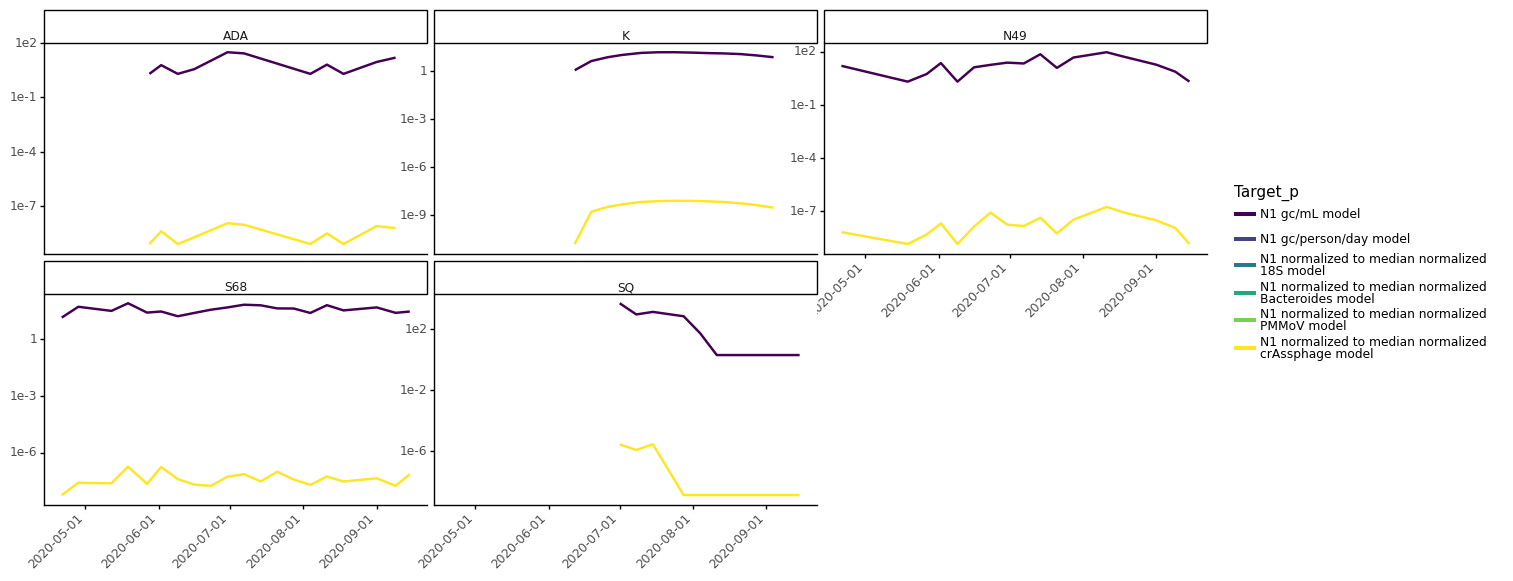

<ggplot: (312760012)>

In [45]:



# hlinedf= pd.DataFrame({'Target': [name_N1C_int.format(round(alpha,2)),name_N1_int.format(round(alpha,2)), name_new_cases],
#         'h_val': [N1_LoD/1000,N1_LoD/1000,0.999], 'color':['black','black','white']
#         }, columns = ['Target', 'h_val', 'color'])

a.loc[a.Target_p=="N1C_int", "Target_p"]= name_N1C
a.loc[a.Target_p=="N1_int", "Target_p"]= name_N1
# a.loc[a.Target_p=="new_cases", "Target_p"]= name_new_cases
a.loc[a.Target_p=="N1Fa_int", "Target_p"]= name_N1Fa
a.loc[a.Target_p=="N1P_int", "Target_p"]= name_N1P
a.loc[a.Target_p=="N1b_int", "Target_p"]= name_N1b
a.loc[a.Target_p=="N1S_int", "Target_p"]= name_N1S

plt = (ggplot(a, aes(x='date_sampling', y='model', color= 'Target_p')) + 
# geom_point(a, aes(x='date_sampling', y='value'))+
# geom_pointrange(a, aes(x='date_sampling', y='value', ymin='ymin', ymax='ymax')) +
geom_line(a, aes(x='date_sampling', y='model', color='Target_p'), size=lw)+
# scale_linetype_manual(values=c("solid", "dashed", "twodash", "dotted", "dotdash", "longdash"))+
# geom_hline(hlinedf,aes(yintercept='h_val'), linetype='dashed', color=hlinedf.color)+
ylab('')+
xlab("")+
scale_color_cmap_d('viridis')+
scale_y_log10()+
facet_wrap('~location', ncol=3, scales='free_y')+ #, 
theme_classic()+ theme(legend_position='right', strip_text_x = element_text(margin={'t': 15}), axis_text_x=element_text(rotation=45, hjust=1), figure_size=(15, 6)) )

plt

## Normalized N1 comparison to case data 

In [46]:
#need df with N1 normalized to FCCs (NOT median normalized) in long format and case data as a separate column
f= ["N1_cBOD"]
l= ["E"]
a=wfsc_norm_loc_long.copy() #[wfsc_norm_loc_long.blod_N1 == "N"] #

a= a[~a.Target.isin(f)] 
a= a[~a.location.isin(l)] 


n=a.groupby(["location", "Target", "date_sampling", "population", "moving_average_new_cases_pc"]).agg( value= ("value", lambda x: sci.gmean(x,axis=0)), blod_N1= ("blod_N1", lambda x: "Y" if any(x=="Y") else "N" ), blod_case= ("blod_case", lambda x: "Y" if any(x=="Y") else "N" )).reset_index()
# wfsc_norm_loc_long["blod"]= np.nan
# wfsc_norm_loc_long.loc[(wfsc_norm_loc_long.blod_N1=="Y") & (wfsc_norm_loc_long.blod_case == "Y"), "blod" ] = "both"
# wfsc_norm_loc_long.loc[(wfsc_norm_loc_long.blod_N1=="Y") & (wfsc_norm_loc_long.blod_case == "N"), "blod" ] = "N1"
# wfsc_norm_loc_long.loc[(wfsc_norm_loc_long.blod_N1=="N") & (wfsc_norm_loc_long.blod_case == "Y"), "blod" ] = "case"
# wfsc_norm_loc_long.loc[(wfsc_norm_loc_long.blod_N1=="N") & (wfsc_norm_loc_long.blod_case == "N"), "blod" ] = "none"
n["blod"]= np.nan
n.loc[(n.blod_N1=="Y") & (n.blod_case == "Y"), "blod" ] = "both"
n.loc[(n.blod_N1=="Y") & (n.blod_case == "N"), "blod" ] = "N1"
n.loc[(n.blod_N1=="N") & (n.blod_case == "Y"), "blod" ] = "case"
n.loc[(n.blod_N1=="N") & (n.blod_case == "N"), "blod" ] = "none"
n


,location,Target,date_sampling,population,moving_average_new_cases_pc,value,blod_N1,blod_case,blod
0,ADA,N1,2020-05-28,8.28E+04,9.49E-06,2.00E+03,Y,Y,both
1,ADA,N1,2020-06-02,8.28E+04,9.49E-06,6.09E+03,N,Y,case
2,ADA,N1,2020-06-09,8.28E+04,9.49E-06,2.00E+03,Y,Y,both
3,ADA,N1,2020-06-16,8.28E+04,9.49E-06,3.67E+03,Y,Y,both
4,ADA,N1,2020-06-30,8.28E+04,3.79E-05,3.15E+04,N,N,none
...,...,...,...,...,...,...,...,...,...
418,SQ,N1_flow,2020-08-11,3.14E+03,4.09E-04,4.88E+03,Y,N,N1
419,SQ,N1_flow,2020-08-18,3.13E+03,4.57E-05,4.88E+03,Y,N,N1
420,SQ,N1_flow,2020-08-25,3.11E+03,2.30E-05,4.88E+03,Y,Y,both
421,SQ,N1_flow,2020-09-01,3.08E+03,4.63E-05,4.88E+03,Y,N,N1


In [47]:
#correlation with kendall tau-b 
a=n.copy()

w= n[n.Target== "N1_b"]
[b_r, b_p] = stats.kendalltau(w.value, w.moving_average_new_cases_pc)
b_n= len(w)
b_all= [b_r, b_p, b_n]

w= n[n.Target== "N1_P"]
[P_r, P_p] = stats.kendalltau(w.value, w.moving_average_new_cases_pc)
P_n= len(w)
P_all= [P_r, P_p, P_n]

w= n[n.Target== "N1_c"]
[c_r, c_p] = stats.kendalltau(w.value, w.moving_average_new_cases_pc)
c_n= len(w)
c_all= [c_r, c_p, c_n]

w= n[n.Target== "N1_S"]
[S_r, S_p] = stats.kendalltau(w.value, w.moving_average_new_cases_pc)
S_n= len(w)
S_all= [S_r, S_p, S_n]

w= n[n.Target== "N1"]
[N_r, N_p] = stats.kendalltau(w.value, w.moving_average_new_cases_pc)
N_n= len(w)
N_all= [N_r, N_p, N_n]

w= n[n.Target== "N1_TSS"]
[T_r, T_p] = stats.kendalltau(w.value, w.moving_average_new_cases_pc)
T_n= len(w)
T_all= [T_r, T_p, T_n]

w= n[n.Target== "N1_COD"]
[C_r, C_p] = stats.kendalltau(w.value, w.moving_average_new_cases_pc)
C_n= len(w)
C_all= [C_r, C_p, C_n]

# w= n[n.Target== "N1_cBOD"]
# [cB_r, cB_p] = stats.kendalltau(w.value, w.moving_average_new_cases_pc)

w= n[n.Target== "N1_fa"]
[fa_r, fa_p] = stats.kendalltau(w.value, w.moving_average_new_cases_pc)
fa_n= len(w)
fa_all= [fa_r, fa_p, fa_n]

w= n[n.Target== "N1_flow"]
[f_r, f_p] = stats.kendalltau(w.value, w.moving_average_new_cases_pc)
f_n= len(w)
f_all= [f_r, f_p, f_n]




r= [b_r, P_r, c_r,S_r,N_r,T_r,C_r,fa_r, f_r ]
p= [b_p, P_p, c_p,S_p, N_p, T_p,C_p,  fa_p, f_p]
kendall_fcc1 = pd.DataFrame([r, p], index = [ 'r', 'p'], columns= ['bact', 'PMMoV', "crAss", "18S", "N1", "TSS", "COD", "flow_avg", "flow"]) 

kendall_fcc = pd.DataFrame((N_all, fa_all, c_all, P_all, b_all, S_all, T_all), 
                           index= ["raw N1", "N1 to avg per cap flow", "N1 to crAss", "N1 to PMMoV", "N1 to Bacteroides", "N1 to 18S", "N1 to TSS"], 
                           columns=  ["Correlation to case data", "p value", "n"])
kendall_fcc.columns = pd.MultiIndex.from_tuples(zip(['All data', 'All data', "All data"], kendall_fcc.columns))
kendall_fcc

All data             
                       Correlation to case data  p value   n
raw N1                                 4.27E-01 1.85E-07  72
N1 to avg per cap flow                 4.50E-01 2.91E-08  72
N1 to crAss                            3.82E-01 2.48E-06  72
N1 to PMMoV                            1.80E-01 3.14E-02  68
N1 to Bacteroides                      3.49E-01 1.70E-05  72
N1 to 18S                              4.46E-01 3.62E-03  23
N1 to TSS                              2.18E-01 2.03E-01  19

In [48]:
n=n[n.blod=="none"] #find correlations off data without blod values (for N1 and cases)

w= n[n.Target== "N1_b"]
[b_r, b_p] = stats.kendalltau(w.value, w.moving_average_new_cases_pc)
b_n= len(w)
b_all= [round(b_r,2), b_p, b_n]

w= n[n.Target== "N1_P"]
[P_r, P_p] = stats.kendalltau(w.value, w.moving_average_new_cases_pc)
P_n= len(w)
P_all= [P_r, P_p, P_n]

w= n[n.Target== "N1_c"]
[c_r, c_p] = stats.kendalltau(w.value, w.moving_average_new_cases_pc)
c_n= len(w)
c_all= [c_r, c_p, c_n]

w= n[n.Target== "N1_S"]
[S_r, S_p] = stats.kendalltau(w.value, w.moving_average_new_cases_pc)
S_n= len(w)
S_all= [S_r, S_p, S_n]

w= n[n.Target== "N1"]
[N_r, N_p] = stats.kendalltau(w.value, w.moving_average_new_cases_pc)
N_n= len(w)
N_all= [N_r, N_p, N_n]

w= n[n.Target== "N1_TSS"]
[T_r, T_p] = stats.kendalltau(w.value, w.moving_average_new_cases_pc)
T_n= len(w)
T_all= [T_r, T_p, T_n]

w= n[n.Target== "N1_COD"]
[C_r, C_p] = stats.kendalltau(w.value, w.moving_average_new_cases_pc)
C_n= len(w)
C_all= [C_r, C_p, C_n]

# w= n[n.Target== "N1_cBOD"]
# [cB_r, cB_p] = stats.kendalltau(w.value, w.moving_average_new_cases_pc)

w= n[n.Target== "N1_fa"]
[fa_r, fa_p] = stats.kendalltau(w.value, w.moving_average_new_cases_pc)
fa_n= len(w)
fa_all= [fa_r, fa_p, fa_n]

w= n[n.Target== "N1_flow"]
[f_r, f_p] = stats.kendalltau(w.value, w.moving_average_new_cases_pc)
f_n= len(w)
f_all= [f_r, f_p, f_n]


# r= [b_r, P_r, c_r,S_r,N_r,T_r,C_r,fa_r, f_r ]
# p= [b_p, P_p, c_p,S_p, N_p, T_p,C_p,  fa_p, f_p]
# kendall_fcc = pd.DataFrame([r, p], index = [ 'r', 'p'], columns= ['bact', 'PMMoV', "crAss", "18S", "N1", "TSS", "COD", "flow_avg", "flow"]) 
kendall_fcc_noblod = pd.DataFrame((N_all, fa_all, c_all, P_all, b_all, S_all, T_all), 
                           index= ["raw N1", "N1 to avg per cap flow", "N1 to crAss", "N1 to PMMoV", "N1 to Bacteroides", "N1 to 18S", "N1 to TSS"], 
                           columns=  ["Correlation to case data", "p value", "n"])
kendall_fcc_noblod.columns = pd.MultiIndex.from_tuples(zip(['Without BLoD', 'Without BLoD', "Without BLoD"], kendall_fcc_noblod.columns))


In [49]:
kendall_full = pd.concat([kendall_fcc, kendall_fcc_noblod], axis=1)

# kendall_full.to_csv('kendall_correlation_table.csv') 
# files.download('kendall_correlation_table.csv')

kendall_full

All data               \
                       Correlation to case data  p value   n   
raw N1                                 4.27E-01 1.85E-07  72   
N1 to avg per cap flow                 4.50E-01 2.91E-08  72   
N1 to crAss                            3.82E-01 2.48E-06  72   
N1 to PMMoV                            1.80E-01 3.14E-02  68   
N1 to Bacteroides                      3.49E-01 1.70E-05  72   
N1 to 18S                              4.46E-01 3.62E-03  23   
N1 to TSS                              2.18E-01 2.03E-01  19   

                                   Without BLoD               
                       Correlation to case data  p value   n  
raw N1                                 4.20E-01 2.14E-05  49  
N1 to avg per cap flow                 4.28E-01 1.45E-05  49  
N1 to crAss                            2.95E-01 2.78E-03  49  
N1 to PMMoV                            4.45E-02 6.60E-01  47  
N1 to Bacteroides                      3.10E-01 1.30E-03  51  
N1 to 18S                              7.71E-01 1.01E-05  15  
N1 to TSS                              1.56E-01 6.01E-01  10

In [50]:
N_all

[0.41975342874656035, 2.1372028133101536e-05, 49]

In [51]:
#naming of non median normalized parameters

#insert {} where variable needs to go
#p value code: *= <0.05,  ***= <0.0001 (1e-4)

name_N1 = "N1 (gc/L)\nKendall's tau-b= {}***\n"
name_N1c = "N1 / crAssphage (unitless)\nKendall's tau-b= {}***\n"
name_N1P = "N1 / PMMoV (unitless)\nKendall's tau-b= {}*\n"
name_N1b = "N1 / Bacteroides rRNA (unitless)\nKendall's tau-b= {}***\n"
name_N1S = "N1 / 18S rRNA ratio\nKendall's tau-b= {}\n\n"
name_N1fa = "N1 (gc/person/day)\nKendall's tau-b={}***\n"
name_N1COD = "N1 / COD (gc/mg)\nKendall's tau-b={}\n\n"
name_N1TSS = "N1 / TSS (gc/mg)\nKendall's tau-b={}\n\n"

## Comparison to clinical data (biomarkers)

### Figure 2

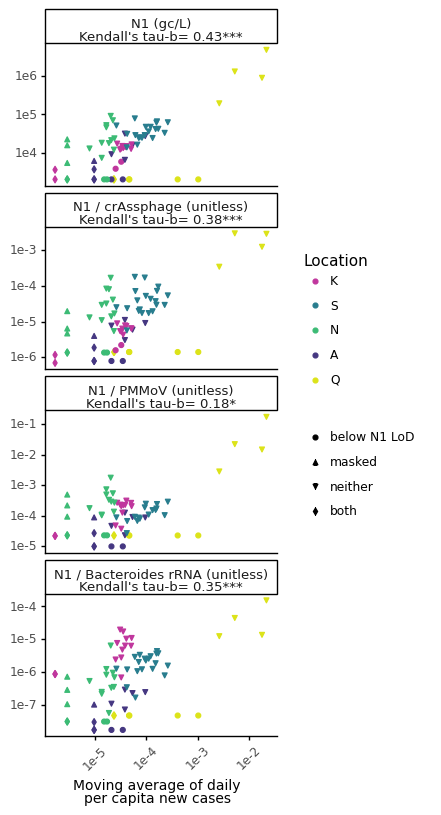

<ggplot: (-9223372036541114694)>

In [52]:
#Scatter plots

#set the order of the x axis
a.loc[a.location=="S68", "location"]= "S"
a.loc[a.location=="N49", "location"]= "N"
a.loc[a.location=="ADA", "location"]= "A"
a.loc[a.location=="SQ", "location"]= "Q"
interceptorLabels = ["K",  "S", "N", "A","Q"]
I_catType = CategoricalDtype(categories = interceptorLabels, ordered = True)
a['location'] = a['location'].astype(I_catType)

#set order for blod shapes
a.loc[a.blod == "case", "blod"]= "masked"
a.loc[a.blod == "N1", "blod"]= "below N1 LoD"
a.loc[a.blod == "none", "blod"]= "neither"
shapeLabels = ["below N1 LoD", "masked","neither",   "both"]
I_catType = CategoricalDtype(categories = shapeLabels, ordered = True)
a['blod'] = a['blod'].astype(I_catType)

nope= [  "N1_S", "N1_flow", "N1_COD", "N1_TSS", "N1_fa"]
a= a[~a.Target.isin(nope)]

#set target names
a["Target_p"]=a.Target
a.loc[a.Target=="N1", "Target"]= name_N1.format(round(kendall_fcc1.N1[0],2))
a.loc[a.Target=="N1_c", "Target"]= name_N1c.format(round(kendall_fcc1.crAss[0],2))
a.loc[a.Target=="N1_P", "Target"]= name_N1P.format(round(kendall_fcc1.PMMoV[0],2))
a.loc[a.Target=="N1_b", "Target"]= name_N1b.format(round(kendall_fcc1.bact[0],2))
# a.loc[a.Target=="N1_S", "Target"]= name_N1S
# a.loc[a.Target=="N1_fa", "Target"]= name_N1fa.format(round(kendall_fcc1.flow_avg[0],2))
# a.loc[a.Target=="N1_flow", "Target"]= name_N1f
# a.loc[a.Target=="N1_COD", "Target"]= name_N1COD
# a.loc[a.Target=="N1_TSS", "Target"]= name_N1TSS

#set the order of facets
targetLabels = [name_N1.format(round(kendall_fcc1.N1[0],2)),name_N1c.format(round(kendall_fcc1.crAss[0],2)), name_N1P.format(round(kendall_fcc1.PMMoV[0],2)), name_N1b.format(round(kendall_fcc1.bact[0],2)) ]
I_catType = CategoricalDtype(categories = targetLabels, ordered = True)
a['Target'] = a['Target'].astype(I_catType)

plt = (ggplot(a, aes(x='moving_average_new_cases_pc', y='value',  color= 'location')) + #, color= 'location'
geom_point(aes(shape= "blod"))+
# geom_smooth(method = "lm", se=False, color="black") +
# geom_pointrange(a, aes(x='date_sampling', y='value', ymin='ymin', ymax='ymax')) +
# geom_line(a, aes(x='date_sampling', y='model', color='Target_p'), size=lw)+
# scale_linetype_manual(values=c("solid", "dashed", "twodash", "dotted", "dotdash", "longdash"))+
# geom_hline(hlinedf,aes(yintercept='h_val'), linetype='dashed', color=hlinedf.color)+
xlab("Moving average of daily\nper capita new cases")+
ylab("")+
# scale_color_cmap_d('viridis')+
scale_color_manual([k_c,s68_c, n49_c, ada_c, sq_c])+
scale_shape_manual(values=(["o", "^", "v", "d"]))+
scale_y_log10()+
scale_x_log10()+
facet_wrap('~Target', ncol=1, scales='free_y')+ #, 
labs(color="Location", shape="")+
theme_classic()+ theme( legend_position='right', strip_text_x = element_text(margin={'t': 15}),strip_text=element_text(size=9.5), axis_text_x=element_text(rotation=45, hjust=2), figure_size=(3, 9),  axis_title=element_text(size=10),) )

#title for the plot
n1='Figure_2' 
plot1=n1  +'.pdf'
#path for the plot
path=os.path.join(dir, plot1)
#save the plot
plt.save(path)


plt

## Variability analysis

In [53]:
#this gets rid of replicates 2 and 3 in wfsc_norm

r=['2','3']
i=["INF","SQ","S68","ADA","N49"]
# wfsc_norm=qpcr_averaged_merged_wide[~((qpcr_averaged_merged_wide.utility=="K") & (qpcr_averaged_merged_wide.replicate.isin(r))) ].copy()
wfsc_norm=wfsc_norm[~((wfsc_norm.utility=="K") & (wfsc_norm.replicate.isin(r))) ].copy()
wfsc_norm=wfsc_norm[~((wfsc_norm.utility=="E") & (wfsc_norm.replicate.isin(r))) ].copy()
wfsc_norm=wfsc_norm[wfsc_norm.interceptor.isin(i)].copy()


fcc= wfsc_norm[~np.isnan(wfsc_norm.N1)]

In [54]:
fcc_loc=fcc[fcc.utility =="K"]

#creating time series of each parameter in units of fcc copies/person/day
# fcc(cp/L) * flow (MGD) * 3785411.78 L/MG * 1/population = fcc cp/day/person
fcc_loc["N1_per_cap"] =fcc_loc["N1"]*fcc_loc["average_flow_MGD"]*3785411.78/fcc_loc["population"]
fcc_loc["PMMoV_per_cap"] =fcc_loc["PMMoV"]*fcc_loc["average_flow_MGD"]*3785411.78/fcc_loc["population"]
fcc_loc["crAss_per_cap"] =fcc_loc["crAss"]*fcc_loc["average_flow_MGD"]*3785411.78/fcc_loc["population"]
fcc_loc["18S_per_cap"] =fcc_loc["18S"]*fcc_loc["average_flow_MGD"]*3785411.78/fcc_loc["population"]
fcc_loc["bact_per_cap"] =fcc_loc["bact"]*fcc_loc["average_flow_MGD"]*3785411.78/fcc_loc["population"]
fcc_loc["TSS_per_cap"] =fcc_loc["TSS_mgL"]*fcc_loc["average_flow_MGD"]*3785411.78/fcc_loc["population"]

fcc_K = [median(fcc_loc.PMMoV), median(fcc_loc["18S"]), median(fcc_loc.crAss), median(fcc_loc.bact), median(fcc_loc.N1_per_cap), median(fcc_loc.PMMoV_per_cap), median(fcc_loc["18S_per_cap"]),  median(fcc_loc.crAss_per_cap), median(fcc_loc.bact_per_cap), median(fcc_loc.TSS_per_cap)]

#convert to long format for plotting
fcc_loc_long= fcc_loc[["date_sampling", "utility", "interceptor","replicate", "N1_per_cap", "18S_per_cap", "crAss_per_cap", "PMMoV_per_cap", "bact_per_cap", "18S", "crAss", "PMMoV", "bact"]]
fcc_loc_long.interceptor = fcc_loc_long.utility
#next line scales and centers the data
# fcc_loc_long[["N1_per_cap", "18S_per_cap", "crAss_per_cap", "PMMoV_per_cap", "bact_per_cap"]]= preprocessing.scale(fcc_loc_long[["N1_per_cap", "18S_per_cap", "crAss_per_cap", "PMMoV_per_cap", "bact_per_cap"]])
fcc_loc_long= fcc_loc_long.melt(id_vars= ["date_sampling", "utility", "interceptor", "replicate"], 
                               value_vars= ["N1_per_cap", "18S_per_cap", "crAss_per_cap", "PMMoV_per_cap", "bact_per_cap", "18S", "crAss", "PMMoV", "bact"], 
                               var_name= "Target" )

fcc_loc_long.value = pd.to_numeric(fcc_loc_long.value, errors='coerce')
fcc_loc_long_K = fcc_loc_long.dropna()

In [55]:
#location fcc comparison -- San Jose
fcc_loc=fcc[fcc.utility =="E"]
# pop_E= 1400000

#creating time series of each parameter in units of fcc copies/person/day
# fcc(cp/L) * flow (MGD) * 3785411.78 L/MG * 1/population = fcc cp/day/person
fcc_loc["N1_per_cap"] =fcc_loc["N1"]*fcc_loc["average_flow_MGD"]*3785411.78/fcc_loc["population"]
fcc_loc["PMMoV_per_cap"] =fcc_loc["PMMoV"]*fcc_loc["average_flow_MGD"]*3785411.78/fcc_loc["population"]
fcc_loc["crAss_per_cap"] =fcc_loc["crAss"]*fcc_loc["average_flow_MGD"]*3785411.78/fcc_loc["population"]
fcc_loc["18S_per_cap"] =fcc_loc["18S"]*fcc_loc["average_flow_MGD"]*3785411.78/fcc_loc["population"]
fcc_loc["bact_per_cap"] =fcc_loc["bact"]*fcc_loc["average_flow_MGD"]*3785411.78/fcc_loc["population"]
fcc_loc["TSS_per_cap"] =fcc_loc["TSS_mgL"]*fcc_loc["average_flow_MGD"]*3785411.78/fcc_loc["population"]

fcc_E = [median(fcc_loc.PMMoV), median(fcc_loc["18S"]), median(fcc_loc.crAss), median(fcc_loc.bact), median(fcc_loc.N1_per_cap.dropna()), median(fcc_loc.PMMoV_per_cap.dropna()), median(fcc_loc["18S_per_cap"].dropna()),  median(fcc_loc.crAss_per_cap.dropna()), median(fcc_loc.bact_per_cap.dropna()), median(fcc_loc.TSS_per_cap.dropna())]

#convert to long format for plotting
fcc_loc_long= fcc_loc[["date_sampling", "utility", "interceptor","replicate", "N1_per_cap", "18S_per_cap", "crAss_per_cap", "PMMoV_per_cap", "bact_per_cap", "18S", "crAss", "PMMoV", "bact"]]
fcc_loc_long.interceptor = fcc_loc_long.utility
# fcc_loc_long[["N1_per_cap", "18S_per_cap", "crAss_per_cap", "PMMoV_per_cap", "bact_per_cap"]]= preprocessing.scale(fcc_loc_long[["N1_per_cap", "18S_per_cap", "crAss_per_cap", "PMMoV_per_cap", "bact_per_cap"]])
fcc_loc_long= fcc_loc_long.melt(id_vars= ["date_sampling", "utility", "interceptor", "replicate"], 
                               value_vars= ["N1_per_cap", "18S_per_cap", "crAss_per_cap", "PMMoV_per_cap", "bact_per_cap", "18S", "crAss", "PMMoV", "bact"], 
                               var_name= "Target" )

fcc_loc_long.value = pd.to_numeric(fcc_loc_long.value, errors='coerce')
fcc_loc_long_E = fcc_loc_long.dropna()

In [56]:
#location fcc comparison -- SQ
fcc_loc=fcc[fcc.interceptor =="SQ"]

#creating time series of each parameter in units of fcc copies/person/day
# fcc(cp/L) * flow (MGD) * 3785411.78 L/MG * 1/population = fcc cp/day/person
fcc_loc.population = pd.to_numeric(fcc_loc.population, errors='coerce')
fcc_loc["N1_per_cap"] =fcc_loc["N1"]*fcc_loc["average_flow_MGD"]*3785411.78/fcc_loc["population"]
fcc_loc["PMMoV_per_cap"] =fcc_loc["PMMoV"]*fcc_loc["average_flow_MGD"]*3785411.78/fcc_loc["population"]
fcc_loc["crAss_per_cap"] =fcc_loc["crAss"]*fcc_loc["average_flow_MGD"]*3785411.78/fcc_loc["population"]
fcc_loc["18S_per_cap"] =fcc_loc["18S"]*fcc_loc["average_flow_MGD"]*3785411.78/fcc_loc["population"]
fcc_loc["bact_per_cap"] =fcc_loc["bact"]*fcc_loc["average_flow_MGD"]*3785411.78/fcc_loc["population"]
fcc_loc["TSS_per_cap"] =fcc_loc["TSS_mgL"]*fcc_loc["average_flow_MGD"]*3785411.78/fcc_loc["population"]

fcc_SQ = [median(fcc_loc.PMMoV), median(fcc_loc["18S"]), median(fcc_loc.crAss), median(fcc_loc.bact), median(fcc_loc.N1_per_cap), median(fcc_loc.PMMoV_per_cap), median(fcc_loc["18S_per_cap"]),  median(fcc_loc.crAss_per_cap), median(fcc_loc.bact_per_cap), median(fcc_loc.TSS_per_cap)]

#convert to long format for plotting
fcc_loc_long= fcc_loc[["date_sampling", "utility", "interceptor","replicate", "N1_per_cap", "PMMoV_per_cap","18S_per_cap", "crAss_per_cap",  "bact_per_cap", "18S", "crAss", "PMMoV", "bact"]]
# fcc_loc_long[["N1_per_cap", "18S_per_cap", "crAss_per_cap", "PMMoV_per_cap", "bact_per_cap"]]= preprocessing.scale(fcc_loc_long[["N1_per_cap", "18S_per_cap", "crAss_per_cap", "PMMoV_per_cap", "bact_per_cap"]])
fcc_loc_long= fcc_loc_long.melt(id_vars= ["date_sampling", "utility", "interceptor", "replicate"], 
                               value_vars= ["N1_per_cap", "18S_per_cap", "crAss_per_cap", "PMMoV_per_cap", "bact_per_cap", "18S", "crAss", "PMMoV", "bact"], 
                               var_name= "Target" )

fcc_loc_long.value = pd.to_numeric(fcc_loc_long.value, errors='coerce')
fcc_loc_long_SQ = fcc_loc_long.dropna()

In [57]:
#location fcc comparison -- EBMUD S68
fcc_loc=fcc[fcc.interceptor =="S68"]
# flow_S68= 35
# pop_S68= 469344

#creating time series of each parameter in units of fcc copies/person/day
# fcc(cp/L) * flow (MGD) * 3785411.78 L/MG * 1/population = fcc cp/day/person
fcc_loc["N1_per_cap"] =fcc_loc["N1"]*fcc_loc["average_flow_MGD"]*3785411.78/fcc_loc["population"]
fcc_loc["PMMoV_per_cap"] =fcc_loc["PMMoV"]*fcc_loc["average_flow_MGD"]*3785411.78/fcc_loc["population"]
fcc_loc["crAss_per_cap"] =fcc_loc["crAss"]*fcc_loc["average_flow_MGD"]*3785411.78/fcc_loc["population"]
fcc_loc["18S_per_cap"] =fcc_loc["18S"]*fcc_loc["average_flow_MGD"]*3785411.78/fcc_loc["population"]
fcc_loc["bact_per_cap"] =fcc_loc["bact"]*fcc_loc["average_flow_MGD"]*3785411.78/fcc_loc["population"]
fcc_loc["TSS_per_cap"] =fcc_loc["TSS_mgL"]*fcc_loc["average_flow_MGD"]*3785411.78/fcc_loc["population"]

fcc_S68 = [median(fcc_loc.PMMoV), median(fcc_loc["18S"]), median(fcc_loc.crAss), median(fcc_loc.bact), median(fcc_loc.N1_per_cap.dropna()), median(fcc_loc.PMMoV_per_cap.dropna()), "NA",  median(fcc_loc.crAss_per_cap.dropna()), "NA", "NA"]
#mean(fcc_loc.PMMoV_per_cap.dropna()), this should work, figure out why can't find PMMoV data

#convert to long format for plotting
fcc_loc_long= fcc_loc[["date_sampling", "utility", "interceptor","replicate","N1_per_cap", "PMMoV_per_cap","18S_per_cap", "crAss_per_cap",  "bact_per_cap", "18S", "crAss", "PMMoV", "bact"]]
# fcc_loc_long[["N1_per_cap", "18S_per_cap", "crAss_per_cap", "PMMoV_per_cap", "bact_per_cap"]]= preprocessing.scale(fcc_loc_long[["N1_per_cap", "18S_per_cap", "crAss_per_cap", "PMMoV_per_cap", "bact_per_cap"]])
fcc_loc_long= fcc_loc_long.melt(id_vars= ["date_sampling", "utility", "interceptor","replicate"], 
                               value_vars= ["N1_per_cap", "18S_per_cap", "crAss_per_cap", "PMMoV_per_cap", "bact_per_cap", "18S", "crAss", "PMMoV", "bact"], 
                               var_name= "Target" )

fcc_loc_long.value = pd.to_numeric(fcc_loc_long.value, errors='coerce')
fcc_loc_long_S68 = fcc_loc_long.dropna()

In [58]:
#location fcc comparison -- EBMUD N49
fcc_loc=fcc[fcc.interceptor =="N49"]


#creating time series of each parameter in units of fcc copies/person/day
# fcc(cp/L) * flow (MGD) * 3785411.78 L/MG * 1/population = fcc cp/day/person
fcc_loc["N1_per_cap"] =fcc_loc["N1"]*fcc_loc["average_flow_MGD"]*3785411.78/fcc_loc["population"]
fcc_loc["PMMoV_per_cap"] =fcc_loc["PMMoV"]*fcc_loc["average_flow_MGD"]*3785411.78/fcc_loc["population"]
fcc_loc["crAss_per_cap"] =fcc_loc["crAss"]*fcc_loc["average_flow_MGD"]*3785411.78/fcc_loc["population"]
fcc_loc["18S_per_cap"] =fcc_loc["18S"]*fcc_loc["average_flow_MGD"]*3785411.78/fcc_loc["population"]
fcc_loc["bact_per_cap"] =fcc_loc["bact"]*fcc_loc["average_flow_MGD"]*3785411.78/fcc_loc["population"]
fcc_loc["TSS_per_cap"] =fcc_loc["TSS_mgL"]*fcc_loc["average_flow_MGD"]*3785411.78/fcc_loc["population"]

fcc_N49 = [median(fcc_loc.PMMoV), median(fcc_loc["18S"]), median(fcc_loc.crAss), median(fcc_loc.bact), median(fcc_loc.N1_per_cap.dropna()), "NA", "NA",  median(fcc_loc.crAss_per_cap.dropna()), "NA", "NA"]
#mean(fcc_loc.PMMoV_per_cap.dropna()), this should work, figure out why can't find PMMoV data

#convert to long format for plotting
fcc_loc_long= fcc_loc[["date_sampling", "utility", "interceptor","replicate", "N1_per_cap", "PMMoV_per_cap","18S_per_cap", "crAss_per_cap",  "bact_per_cap", "18S", "crAss", "PMMoV", "bact"]]
# fcc_loc_long[["N1_per_cap", "18S_per_cap", "crAss_per_cap", "PMMoV_per_cap", "bact_per_cap"]]= preprocessing.scale(fcc_loc_long[["N1_per_cap", "18S_per_cap", "crAss_per_cap", "PMMoV_per_cap", "bact_per_cap"]])
fcc_loc_long= fcc_loc_long.melt(id_vars= ["date_sampling", "utility", "interceptor", "replicate"], 
                               value_vars= ["N1_per_cap", "18S_per_cap", "crAss_per_cap", "PMMoV_per_cap", "bact_per_cap", "18S", "crAss", "PMMoV", "bact"], 
                               var_name= "Target" )

fcc_loc_long.value = pd.to_numeric(fcc_loc_long.value, errors='coerce')
fcc_loc_long_N49 = fcc_loc_long.dropna()

In [59]:
#location fcc comparison -- EBMUD ADA
fcc_loc=fcc[fcc.interceptor =="ADA"]


#creating time series of each parameter in units of fcc copies/person/day
# fcc(cp/L) * flow (MGD) * 3785411.78 L/MG * 1/population = fcc cp/day/person
fcc_loc["N1_per_cap"] =fcc_loc["N1"]*fcc_loc["average_flow_MGD"]*3785411.78/fcc_loc["population"]
fcc_loc["PMMoV_per_cap"] =fcc_loc["PMMoV"]*fcc_loc["average_flow_MGD"]*3785411.78/fcc_loc["population"]
fcc_loc["crAss_per_cap"] =fcc_loc["crAss"]*fcc_loc["average_flow_MGD"]*3785411.78/fcc_loc["population"]
fcc_loc["18S_per_cap"] =fcc_loc["18S"]*fcc_loc["average_flow_MGD"]*3785411.78/fcc_loc["population"]
fcc_loc["bact_per_cap"] =fcc_loc["bact"]*fcc_loc["average_flow_MGD"]*3785411.78/fcc_loc["population"]
fcc_loc["TSS_per_cap"] =fcc_loc["TSS_mgL"]*fcc_loc["average_flow_MGD"]*3785411.78/fcc_loc["population"]

fcc_ADA = [median(fcc_loc.PMMoV), median(fcc_loc["18S"]), median(fcc_loc.crAss), median(fcc_loc.bact), median(fcc_loc.N1_per_cap.dropna()), "NA", "NA",  median(fcc_loc.crAss_per_cap.dropna()), "NA", "NA"]
#mean(fcc_loc.PMMoV_per_cap.dropna()), this should work, figure out why can't find PMMoV data

#convert to long format for plotting
fcc_loc_long= fcc_loc[["date_sampling", "utility", "interceptor","replicate", "N1_per_cap", "PMMoV_per_cap","18S_per_cap", "crAss_per_cap",  "bact_per_cap", "18S", "crAss", "PMMoV", "bact"]]
# fcc_loc_long[["N1_per_cap", "18S_per_cap", "crAss_per_cap", "PMMoV_per_cap", "bact_per_cap"]]= preprocessing.scale(fcc_loc_long[["N1_per_cap", "18S_per_cap", "crAss_per_cap", "PMMoV_per_cap", "bact_per_cap"]])
fcc_loc_long= fcc_loc_long.melt(id_vars= ["date_sampling", "utility", "interceptor", "replicate"], 
                               value_vars= ["N1_per_cap", "18S_per_cap", "crAss_per_cap", "PMMoV_per_cap", "bact_per_cap", "18S", "crAss", "PMMoV", "bact"], 
                               var_name= "Target" )

fcc_loc_long.value = pd.to_numeric(fcc_loc_long.value, errors='coerce')
fcc_loc_long_ADA = fcc_loc_long.dropna()

In [60]:
#compare the fcc time MEDIAN across interceptors
fcc_df = [fcc_K, fcc_E, fcc_SQ, fcc_S68, fcc_N49, fcc_ADA]
fcc_df = pd.DataFrame(fcc_df, columns= ["PMMoV","18S", "crAss", "bact", "N1_per_cap", "PMMoV_per_cap","18S_per_cap", "crAss_per_cap",  "bact_per_cap", "TSS_per_cap"], index= ["K", "E", "SQ", "S68", "N49", "ADA"])
fcc_df

,PMMoV,18S,crAss,bact,N1_per_cap,PMMoV_per_cap,18S_per_cap,crAss_per_cap,bact_per_cap,TSS_per_cap
K,8.72E+07,2.06E+08,1.86E+09,2.04E+09,3.63E+06,2.28E+10,5.39E+10,4.86E+11,5.31E+11,7.10E+04
E,7.14E+07,8.99E+04,7.04E+08,1.05E+10,5.22E+04,1.81E+09,1.04E+06,1.84E+10,2.07E+11,7.64E+03
SQ,6.89E+07,4.33E+08,9.47E+08,2.50E+10,1.02E+06,3.22E+10,2.00E+11,4.62E+11,1.24E+13,1.15E+05
S68,3.18E+08,NAN,1.14E+09,1.95E+10,1.00E+07,7.81E+10,NA,3.23E+11,NA,NA
N49,7.24E+07,NAN,1.09E+09,4.47E+10,4.55E+06,NA,NA,2.96E+11,NA,NA
ADA,1.37E+08,NAN,1.66E+09,9.82E+10,1.68E+06,NA,NA,4.54E+11,NA,NA


In [61]:
#create df for boxplots

#boxplots of pop and flow normalized fcc at each location over time
fcc_loc_long= fcc_loc_long_K.append(fcc_loc_long_E)
fcc_loc_long= fcc_loc_long.append(fcc_loc_long_SQ)
fcc_loc_long= fcc_loc_long.append(fcc_loc_long_S68)
fcc_loc_long= fcc_loc_long.append(fcc_loc_long_N49)
fcc_loc_long= fcc_loc_long.append(fcc_loc_long_ADA)
fcc_loc_long= fcc_loc_long[fcc_loc_long.Target != "N1_per_cap"]
fcc_loc_long= fcc_loc_long[~((fcc_loc_long.interceptor == "SQ") & (fcc_loc_long.date_sampling == pd.to_datetime("2020-09-15")))]
# fcc_loc_long= fcc_loc_long[~((fcc_loc_long.interceptor == "E") & (fcc_loc_long.Target == "18S_per_cap"))]
# fcc_loc_long= fcc_loc_long[~((fcc_loc_long.interceptor == "E") & (fcc_loc_long.Target == "18S"))]

#set the order of the x axis
fcc_loc_long.loc[fcc_loc_long.interceptor=="S68", "interceptor"]= "S"
fcc_loc_long.loc[fcc_loc_long.interceptor=="N49", "interceptor"]= "N"
fcc_loc_long.loc[fcc_loc_long.interceptor=="ADA", "interceptor"]= "A"
fcc_loc_long.loc[fcc_loc_long.interceptor=="SQ", "interceptor"]= "Q"
interceptorLabels = ["K",  "S", "N", "A","Q", "E"]
I_catType = CategoricalDtype(categories = interceptorLabels, ordered = True)
fcc_loc_long['interceptor'] = fcc_loc_long['interceptor'].astype(I_catType)



### Figure 1

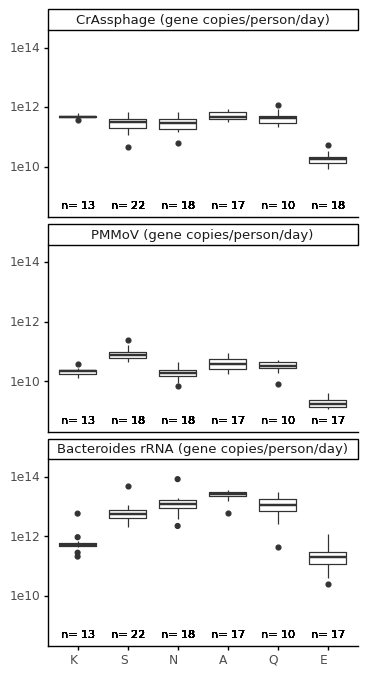

<ggplot: (-9223372036539462954)>

In [62]:
#location comparison boxplot for bact, crass, pmmov

b= fcc_loc_long[~((fcc_loc_long.Target == "18S")| (fcc_loc_long.Target == "18S_per_cap")| (fcc_loc_long.Target == "crAss")| (fcc_loc_long.Target == "PMMoV")| (fcc_loc_long.Target == "bact") )]

                                                     
#naming 
crAss_name = "CrAssphage (gene copies/person/day)"
pmmov_name= "PMMoV (gene copies/person/day)"
bact_name="Bacteroides rRNA (gene copies/person/day)"

b.loc[b.Target=="crAss_per_cap", "Target"]= crAss_name
b.loc[b.Target=="PMMoV_per_cap", "Target"]= pmmov_name
b.loc[b.Target=="bact_per_cap", "Target"]= bact_name

#set order of facet
targetLabels = [ crAss_name, pmmov_name, bact_name] #,"18S_per_cap",  "crAss", "PMMoV", "18S","bact"]
I_catType = CategoricalDtype(categories = targetLabels, ordered = True)
b['Target'] = b['Target'].astype(I_catType)

#get n label
a= b.groupby(["Target","interceptor"]).agg(n=('value', 'count')).reset_index()                                                                 
a['n']='n= '+a['n'].astype('str')  
a['height']=500000000
b=a.merge(b)

plt = (ggplot(b) + 
geom_boxplot(aes(x='interceptor', y='value'))+
scale_y_log10(limits=(400000000, 200000000000000))+
facet_wrap('~Target', ncol=1, scales='fixed')+ #,
geom_text(aes(x= "interceptor", label="n",y= "height"), ha='center', va='center', size= 8)+ 
# scale_color_cmap_d('cividis')+
ylab('')+
xlab("")+
theme_classic()+ theme(legend_position='none', strip_text=element_text(size=9.5), axis_text_x=element_text( hjust=1), figure_size=(4,8)) )

# theme(legend_title=element_text(size=14),legend_position=(.5, -.01),legend_direction='horizontal',axis_title=element_text(size=20), strip_text=element_text(size=14),  legend_text=element_text(size=14),axis_text_x=element_text(rotation=45, hjust=1, size=14), axis_text_y=element_text(size=14),figure_size=(16,14)

#title for the plot
n1='Figure_1' 
plot1=n1  +'.pdf'
#path for the plot
path=os.path.join(dir, plot1)
#save the plot
plt.save(path)


plt

### Figure S8

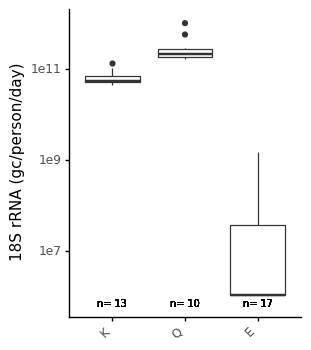

<ggplot: (-9223372036541111152)>

In [63]:
#location comparison boxplot but just for 18S
w= ["K", "E", "Q"]
b= fcc_loc_long[(fcc_loc_long.Target == "18S_per_cap")& (fcc_loc_long.interceptor.isin(w))]
                                               
#naming 
name_18S = "18S rRNA (gc/person/day)"

b.loc[b.Target=="18S_per_cap", "Target"]= name_18S


#get n label
d= b.groupby("interceptor").agg(n=('value', 'count')).reset_index()                                                                 
d['n']='n= '+d['n'].astype('str')  
d=d[(d.interceptor== "K")|(d.interceptor== "E")|(d.interceptor== "Q")]
b=b.merge(d)

plt = (ggplot(b) + 
geom_boxplot(aes(x='interceptor', y='value'))+
scale_y_log10()+
# facet_wrap('~Target', ncol=1, scales='fixed')+ #, 
ylab('18S rRNA (gc/person/day)')+
xlab('')+
geom_text(aes(x= 'interceptor', y= 700000, label='n'),ha='center', va='center', size= 7)+
theme_classic()+ theme(axis_text_x=element_text(rotation=45, hjust=1), figure_size=(3,4)) )

#title for the plot
n1='Figure_S8' 
plot1=n1  +'.pdf'
#path for the plot
path=os.path.join(dir, plot1)
#save the plot
plt.save(path)


plt

## Statistical significance

In [64]:
#Determining statistical significance of above boxplots
dfm=fcc_loc_long[fcc_loc_long.Target == "PMMoV_per_cap"]
# dfm=dfm[~(dfm.interceptor == "E")]
groups="interceptor"

g=fcc_loc_long[groups].unique()

gK=dfm.loc[dfm[groups]==g[0],"value"]
gE=dfm.loc[dfm[groups]==g[1],"value"]
gSQ=dfm.loc[dfm[groups]==g[2],"value"]
gS68=dfm.loc[dfm[groups]==g[3],"value"]
gN49=dfm.loc[dfm[groups]==g[4],"value"]
gADA=dfm.loc[dfm[groups]==g[5],"value"]


data=[gK, gE, gSQ, gS68, gN49, gADA]
sci.kruskal(gK, gE, gSQ, gS68, gN49, gADA)

#15 tests when comparing 6 groups pairwise. Bonferroni correction would mean our new p value threshold is 0.05/15= 0.0033
#when we remove interceptor E, crAss kruskal p value is 0.0014

# x=pd.DataFrame(sp.posthoc_dunn(data))
# x.columns=['K', 'E', 'SQ', 'S68', 'N49', 'ADA']
# x.index=['K', 'E', 'SQ', 'S68', 'N49', 'ADA']
# x #<=0.05 #true means they're statistically different

KruskalResult(statistic=71.66316387350741, pvalue=4.616948639898484e-14)

## Biomarker time analysis (loads)

In [65]:
#in previous section, compared flow-scaled biomarker loads for spatial variations
#in this section, compare temporal variation of loads within each location 

#subset for all biomarkers
b= fcc_loc_long[~((fcc_loc_long.Target == "18S")| (fcc_loc_long.Target == "crAss")| (fcc_loc_long.Target == "PMMoV")| (fcc_loc_long.Target == "bact") )]

fcc_time_loc = b.groupby(["Target", "interceptor"]).agg(time_loc_mean=("value", lambda x: sci.gmean(x,axis=0)), time_loc_std= ("value", lambda x: np.nan if ( (len(x.dropna()) <2 ) ) else (sci.gstd(x.dropna(),axis=0)))).reset_index()
fcc_time_loc["cov_time_loc"]= fcc_time_loc.time_loc_std - 1
fcc_time_loc

,Target,interceptor,time_loc_mean,time_loc_std,cov_time_loc
0,18S_per_cap,K,6.15E+10,1.39E+00,3.91E-01
1,18S_per_cap,S,NAN,NAN,NAN
2,18S_per_cap,N,NAN,NAN,NAN
3,18S_per_cap,A,NAN,NAN,NAN
4,18S_per_cap,Q,2.66E+11,1.81E+00,8.06E-01
5,18S_per_cap,E,8.70E+06,1.48E+01,1.38E+01
6,PMMoV_per_cap,K,2.12E+10,1.32E+00,3.21E-01
7,PMMoV_per_cap,S,8.30E+10,1.61E+00,6.07E-01
8,PMMoV_per_cap,N,1.93E+10,1.59E+00,5.94E-01
9,PMMoV_per_cap,A,4.02E+10,1.69E+00,6.94E-01


In [66]:
#find the average geometric covariance for each biomarker (to show average variability over time)
fcc_time = fcc_time_loc.groupby(["Target"]).agg(gcov_mean=("cov_time_loc", 'mean'))
fcc_time

,gcov_mean
Target,
18S_per_cap,5.00E+00
PMMoV_per_cap,5.62E-01
bact_per_cap,1.30E+00
crAss_per_cap,5.91E-01


In [67]:
#test statistical significance of difference in means (of geometric covariances)

#plot histograms to test normality (doesn't work bc not enough points)
# pltA= (ggplot(fcc_time_loc, aes(x='cov_time_loc')) + 
#        geom_histogram(bins=5)+
#        facet_wrap('~Target', ncol=2, scales='free_x'))
# pltA

#t test 
crAss= fcc_time_loc.cov_time_loc[fcc_time_loc.Target == "crAss_per_cap"]
pmmov= fcc_time_loc.cov_time_loc[fcc_time_loc.Target == "PMMoV_per_cap"]
bact= fcc_time_loc.cov_time_loc[fcc_time_loc.Target == "bact_per_cap"]
S18= fcc_time_loc.cov_time_loc[fcc_time_loc.Target == "18S_per_cap"]

stats.ttest_ind(crAss.dropna(), pmmov.dropna(), equal_var = False) #p value >0.05 means they're the same
stats.ttest_ind(crAss.dropna(), bact.dropna(), equal_var = False) #p value of 0.047 means they're different
stats.ttest_ind(crAss.dropna(), S18.dropna(), equal_var = False) #not enough points to test 18S
stats.ttest_ind(pmmov.dropna(), bact.dropna(), equal_var = False) #pmmov and bact are different


Ttest_indResult(statistic=-2.681361796542609, pvalue=0.03953266486067397)